## Imports 

In [1]:
import numpy as np

import scipy as sp
import scipy.stats as stats
from scipy.stats import linregress,t
from scipy.optimize import curve_fit

import HPOpt as hp

import matplotlib.pyplot as plt
from matplotlib import rc
plt.rc('text', usetex=True)
font = {'family' : 'serif',
        'size'   : 14}
plt.rc('font', **font)
plt.rc('ytick', labelsize=20) 
plt.rc('xtick', labelsize=20)

import json

import os
import math

## Basic parameters

In [2]:
# Plotting color
Sham = True
ColLS = True
C = np.array([[166,206,227],
[31,120,180],
[178,223,138],
[51,160,44],
[251,154,153],
[227,26,28],
[253,191,111],
[255,127,0],
[202,178,214],
[106,61,154],
[255,255,153],
            [169,169,169],
             [128,128,128]])
C = C/255.

ColorDict = {'mean':0,'median':1,'Control': 1,'CamKII':3,'Calcineurin':7,'CHX':5,'Anisomycin':9,'Sham':-1,'CamKII_alt':3,'CHX_alt':5,}

labelDict = {'CamKII':'AIP','Calcineurin':'FK506','Control':'Control','Sham':'Sham','CHX':'CHX','Anisomycin':'Anisomycin'}

spineplot = np.arange(1,16,0.5)
lw    = 4
fs    = 20

In [3]:
times = [-15,-10,-5,2,10,20,30,40]

tmin    =  0
tmax    =  40
tpts    =  tmax*1000+1
dt     = (tmax-tmin)/tpts
tvec  = np.linspace(tmin,tmax,tpts)


In [4]:
BaseDir = './'

## Basic Functions

In [5]:
def ReadFiles(Dir):
    Accept = []
    for d in os.listdir(Dir):
        try:
            if('Synapse_l.json' in os.listdir(Dir+d) ):
                Accept.append(d)
        except:
            pass
        
    Syn_a_arr = []
    bg_l      = []
    for a in Accept:
        with open(Dir+a+'/Synapse_l.json', 'r') as fp: Syn_a_arr.append(json.load(fp))
        try:
            bg_l.append(np.load(Dir+a+"/backgroundM.npy").squeeze())
        except:
            bg_l.append(np.load(Dir+a+"/background.npy").squeeze())
    Areas_arr = []
    Dist_arr  = []
    bg_arr = []
    kk = 0
    for Syn_a,bg in zip(Syn_a_arr,bg_l):
        kk+=1
        areas = np.array([S["RawIntDen"] for S in Syn_a])
        bg_arr = np.zeros_like(areas)
        for i, Syn in enumerate(Syn_a):
            bg_arr[i,:] = Syn["area"]*bg/(0.066**2)
        if(not Syn_a[0]["Times"]==times):
            for l in np.sort(list(set(times)-set(Syn_a[0]["Times"]))[::-1]):
                areas = np.insert(areas,times.index(l),math.nan,-1)
                bg_arr = np.insert(bg_arr,times.index(l),math.nan,-1)
                
        dist_a = [S["distance"] for S in Syn_a]
        Dist_arr  = Dist_arr+dist_a
        Areas_arr.append(areas-bg_arr)
    
    Areas_arr_b = np.vstack(Areas_arr)
    Dist_arr_b = np.array(Dist_arr)#    
    Areas_arr_b = (Areas_arr_b.T/Areas_arr_b[:,:3].mean(axis=1)).T
    return Dist_arr_b,Areas_arr_b,(Areas_arr,Dist_arr)

#===================================================================================
#===================================================================================

def ReadFilesSep(Dir):
    Accept = []
    for d in os.listdir(Dir):
        try:
            if('Synapse_l.json' in os.listdir(Dir+d) ):
                Accept.append(d)
        except:
            pass

    Syn_a_arr = []
    bg_l      = []
    for a in Accept:
        with open(Dir+a+'/Synapse_l.json', 'r') as fp: Syn_a_arr.append(json.load(fp))
        try:
            bg_l.append(np.load(Dir+a+"/backgroundM.npy").squeeze())
        except:
            bg_l.append(np.load(Dir+a+"/background.npy").squeeze())
    Areas_arr = []
    Dist_arr  = []
    bg_arr = []
    for Syn_a,bg in zip(Syn_a_arr,bg_l):
        areas = np.array([S["RawIntDen"] for S in Syn_a])
        bg_arr = np.zeros_like(areas)
        for i, Syn in enumerate(Syn_a):
            bg_arr[i,:] = Syn["area"]*bg/(0.066**2)
        if(not Syn_a[0]["Times"]==times):
            for l in np.sort(list(set(times)-set(Syn_a[0]["Times"]))[::-1]):
                areas = np.insert(areas,times.index(l),math.nan,-1)
                bg_arr = np.insert(bg_arr,times.index(l),math.nan,-1)

        dist_a = [S["distance"] for S in Syn_a]
        Dist_arr.append(dist_a)
        temp = areas-bg_arr
        Areas_arr.append((temp.T/temp[:,:3].mean(axis=1)).T)


    Clusts  =np.zeros(len(Syn_a_arr))

    for i,SynArr in enumerate(Syn_a_arr):
        for s1 in SynArr:
            for s2 in SynArr:
                if(s1['type']=='Stim' and s2['type']=='Stim'):
                    Clusts[i] = max(np.linalg.norm(np.array(s1['location'])-np.array(s2['location'])),Clusts[i])
    Clusts = Clusts*0.066

    tStimDist = []
    for Syn_a in Syn_a_arr:
        StimDist = []
        for S in Syn_a:
            if(S['type']=='Stim'):
                temp = 10000
                for S2 in Syn_a:
                    if(S2['type']=='Stim'):
                        if(np.linalg.norm(np.array(S["location"])-np.array(S2["location"]))>0):
                            temp = min(temp,np.linalg.norm(np.array(S["location"])-np.array(S2["location"])))
                StimDist.append(temp)                      
        tStimDist.append(StimDist)

    return Areas_arr,Dist_arr,Clusts,tStimDist
#===================================================================================
#===================================================================================
def PreSortData(RealDat,Flag):
    
    Pot = []
    for d in RealDat:
        if(abs((d[3]-d[:3].mean())/d[:3].std())>1.96 and d[3]-d[:3].mean()>0):
            Pot.append(Flag)
        else:
            Pot.append(not Flag)

    return np.delete(RealDat,Pot,axis=0)

#===================================================================================
#===================================================================================

def FailSuccess(Dir):
    
    D1,A1,_ = ReadFiles(Dir)
    RealDat = A1[D1==0]
    Pot = []
    for d in RealDat:
        if(abs((d[3]-d[:3].mean())/d[:3].std())>1.96 and d[3]-d[:3].mean()>0):
            Pot.append(True)
        else:
            Pot.append(False)
    StimPot = sum(Pot)/len(Pot)
    RealDat = A1[D1<0]
    Pot = []
    for d in RealDat:
        if(abs((d[3]-d[:3].mean())/d[:3].std())>1.96 and d[3]-d[:3].mean()>0):
            Pot.append(True)
        else:
            Pot.append(False)
    try:
        return StimPot,sum(Pot)/len(Pot)
    except:
        return StimPot,0

#===================================================================================
#===================================================================================

def func(x, a, b):
    return (a/(x))+b

### Plot Functions

In [6]:
def PlotSimpleCurve(Dir,Name,Type='stim',ax=None,PlotColor='Control'):
    ls = '-'
    if(Sham):
        D1,A1,_ = ReadFiles(Dir[0])
        DS,AS,_ = ReadFiles(Dir[1])
    else:
        D1,A1,_ = ReadFiles(Dir)
        DS,AS = np.zeros_like(D1),np.zeros_like(A1)
    
    if(Type=='stim'):
        A1 = PreSortData(A1[D1==0],False).T
        AS = AS[DS==0].T
        lc = C[ColorDict[PlotColor]]
    elif(Type=='NoSort'):
        A1 = A1[D1==0].T
        AS = AS[DS==0].T
        lc = C[ColorDict[PlotColor]]
    elif(Type=='Clust' or Type=='clust'):
        A1 = A1[D1<0].T
        AS = AS[DS<0].T
        if(ColLS):
            lc = C[ColorDict[PlotColor]-1]
            ls = '-'
        else:
            lc = C[ColorDict[PlotColor]-1]
    elif(Type=='Outside' or Type=='outside'):
        mask = np.logical_and(D1>0,D1<2)
        maskS = np.logical_and(DS>0,DS<2)
        A1 = A1[mask].T
        AS = AS[maskS].T
        if(ColLS):
            lc = C[ColorDict[PlotColor]-1]
            ls = '-'
        else:
            lc = C[ColorDict[PlotColor]-1]
            
    if(Sham):
        tSig = np.array([0.05>stats.ttest_ind(d1,d2,nan_policy='omit',equal_var=True).pvalue for d1,d2 in zip(A1,AS)])
        vSig = np.array(times).astype(float)
        vSig[~tSig] = math.nan
    else:
        tSig = np.array([0.05>stats.ttest_ind(t,A1[:3,:].flatten(),nan_policy='omit',equal_var=True).pvalue for t in A1[3:,:]])
        vSig = np.array(times[3:]).astype(float)
        vSig[~tSig] = math.nan
    nFlags = False
    if(ax==None):
        fig,ax=plt.subplots(1,1)
        nFlag = True
     
    _,caps,_ = ax.errorbar(x=times,y=np.nanmean(A1.T,axis=0),
                 yerr=stats.sem(A1.T,0,nan_policy='omit'),
                 capsize=5,ls='none',marker='_',ecolor='k',
                 c=lc,elinewidth=1,ms=10,mew=3,capthick=1
                )   
    for cap in caps:
        cap.set_markeredgewidth(1)
    ax.plot(vSig,1*np.ones_like(vSig),'*',color='k',alpha=0.75)
    
    if(Sham):
        with open(Dir[0]+Name+'.json', 'r') as fp: temp = json.load(fp)
    else:
        with open(Dir+Name+'.json', 'r') as fp: temp = json.load(fp)
    CE = hp.ChemEquations(temp['C_init'],temp['P_init'],temp['a'],temp['b1'],temp['b2'],temp['c1'],temp['c2'],temp['nu1'],temp['nu2'])
    
    TS = hp.TS_euler()

    
    _,_,sSol = hp.ForwardSolve(TS,CE,dt,tpts)
    ax.plot(tvec[::1000],sSol[::1000],color=lc,ls='-',marker='.',label='Stimulated',ms=0.1)
    tvec_t = np.insert(tvec,0,-15)
    sSol = [1]+sSol
    
    ax.plot(tvec_t,sSol,color=lc,ls=ls,lw=lw)
    ax.legend(prop={'size': fs},markerscale=150,frameon=False)

    ax.axvline(0,linestyle='--',dashes=(10, 10),color='k')
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.set_xticks(times)
    ax.set_xticklabels([str(t) for t in times])
    
#===================================================================================
#===================================================================================

def PlotFitMultiCurve(Dir1,Dir2,Dir3,DirS,Name,ax='None',Type='stim',PlotColor=['Control']*3):

    D1,A1,_ = ReadFiles(Dir)
    if(Type=='stim'):
        A1 = PreSortData(A1[D1==0],False).T
        lc1 = C[ColorDict[PlotColor[0]]]
    elif(Type=='NoSort'):
        A1 = A1[D1==0].T
        lc1 = C[ColorDict[PlotColor[0]]]
    else:
        A1 = A1[D1<0].T
        lc1 = C[ColorDict[PlotColor[0]]-1]
    
    D2,A2,_ = ReadFiles(Dir2)
    D3,A3,_ = ReadFiles(Dir3)
    
    DS,AS,_ = ReadFiles(DirS)
    
    if(Type=='stim'):
        A2 = A2[D2==0].T
        lc2 = C[ColorDict[PlotColor[1]]]
        A3 = A3[D3==0].T
        lc3 = C[ColorDict[PlotColor[2]]]
        AS = AS[DS==0].T
        lcS = C[ColorDict[PlotColor[3]]]
    else:
        A2 = A2[D2<0].T
        lc2 = C[ColorDict[PlotColor[1]]-1]
        A3 = A3[D3<0].T
        lc3 = C[ColorDict[PlotColor[2]]-1]
        AS = AS[DS<0].T
        lcS = C[ColorDict[PlotColor[3]]-1]
    
    

    _,caps,_ = ax.errorbar(x=times,y=np.nanmean(A1.T,axis=0),
                 yerr=stats.sem(A1.T,0,nan_policy='omit'),
                 capsize=5,ls='none',marker='_',ecolor=lc1,
                 c=lc1,elinewidth=1,ms=10,mew=3,capthick=1
                )   
    for cap in caps:
        cap.set_markeredgewidth(1)
    
    _,caps,_ = ax.errorbar(x=times,y=np.nanmean(A2.T,axis=0),
                 yerr=stats.sem(A2.T,0,nan_policy='omit'),
                 capsize=5,ls='none',marker='_',ecolor=lc2,
                 c=lc2,elinewidth=1,ms=10,mew=3,capthick=1
                )   
    for cap in caps:
        cap.set_markeredgewidth(1)
        
    _,caps,_ = ax.errorbar(x=times,y=np.nanmean(A3.T,axis=0),
                 yerr=stats.sem(A3.T,0,nan_policy='omit'),
                 capsize=5,ls='none',marker='_',ecolor=lc3,
                 c=lc3,elinewidth=1,ms=10,mew=3,capthick=1
                )   
    for cap in caps:
        cap.set_markeredgewidth(1)
    
    _,caps,_ = ax.errorbar(x=times,y=np.nanmean(AS.T,axis=0),
                 yerr=stats.sem(AS.T,0,nan_policy='omit'),
                 capsize=5,ls='none',marker='_',ecolor=lcS,
                 c=lcS,elinewidth=1,ms=10,mew=3,capthick=1
                )   
    for cap in caps:
        cap.set_markeredgewidth(1)
        
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.set_xticks(times)
    ax.set_xticklabels([str(t) for t in times])
    
def barplot_annotate_brackets(num1, num2, data, center, height, yerr=None, dh=.05, barh=.05, fs=20, maxasterix=1,offS=0.6):
    """ 
    Annotate barplot with p-values.

    :param num1: number of left bar to put bracket over
    :param num2: number of right bar to put bracket over
    :param data: string to write or number for generating asterixes
    :param center: centers of all bars (like plt.bar() input)
    :param height: heights of all bars (like plt.bar() input)
    :param yerr: yerrs of all bars (like plt.bar() input)
    :param dh: height offset over bar / bar + yerr in axes coordinates (0 to 1)
    :param barh: bar height in axes coordinates (0 to 1)
    :param fs: font size
    :param maxasterix: maximum number of asterixes to write (for very small p-values)
    """

    if type(data) is str:
        text = data
    else:
        # * is p < 0.05
        # ** is p < 0.005
        # *** is p < 0.0005
        # etc.
        text = ''
        p = .05

        while data < p:
            text += '*'
            p /= 10.

            if maxasterix and len(text) == maxasterix:
                break

        if(np.round(data,3)==0):
            text = r' $p<0.0005$'        
        else:
            text = r' $p$: ' + str(np.round(data,3))
    
    lx, ly = center[num1], height[num1]
    rx, ry = center[num2], height[num2]

    if yerr:
        ly += yerr[num1]
        ry += yerr[num2]

    ax_y0, ax_y1 = plt.gca().get_ylim()
    dh *= (ax_y1 - ax_y0)
    barh *= (ax_y1 - ax_y0)

    y = max(ly, ry) + dh

    barx = [lx, lx, rx, rx]
    bary = [y, y+barh, y+barh, y]
    mid = ((lx+rx)/2, y+barh)

    plt.plot(barx, bary, c='black')

    kwargs = dict(ha='center', va='bottom')
    if fs is not None:
        kwargs['fontsize'] = fs

    plt.text(*mid, text, **kwargs)

    return max(ly, ry)

def PlotSimulationFPCum(Dir,Name,ax=None,Col=C[ColorDict['Control']],Type='Stim',lab=''):
    
    with open(Dir+Name+'.json', 'r') as fp: temp = json.load(fp)
    CE = hp.ChemEquations(temp['C_init'],temp['P_init'],temp['a'],temp['b1'],temp['b2'],temp['c1'],temp['c2'],temp['nu1'],temp['nu2'])

    TS = hp.TS_euler()

    _,pSol,sSol = hp.ForwardSolve(TS,CE,dt,tpts)
    pSol = np.array(pSol)
    Fp = CE.c2*pSol*(np.exp(-(pSol-CE.nu1)**2)-np.exp(-(pSol-CE.nu2)**2))
        
    if(ax==None):
        fig,ax = plt.subplots(1,1,figsize=(3.2,3.2 ))
    ax.plot(tvec,dt*np.cumsum(Fp),color=Col,label=r''+lab,lw=lw)
    
    ax.set_xticks([0,40])
    ax.tick_params(axis="y", labelsize=fs)
    ax.tick_params(axis="x", labelsize=fs)
    leg = ax.legend(prop={'size': fs},loc=7,framealpha=0.5)
    leg.get_frame().set_linewidth(0.0)
    
def PlotSimulationFP(Dir,Name,ax=None,Col=C[ColorDict['Control']],Type='Stim',lab=''):
    
    with open(Dir+Name+'.json', 'r') as fp: temp = json.load(fp)
    CE = hp.ChemEquations(temp['C_init'],temp['P_init'],temp['a'],temp['b1'],temp['b2'],temp['c1'],temp['c2'],temp['nu1'],temp['nu2'])

    TS = hp.TS_euler()

    _,pSol,_ = hp.ForwardSolve(TS,CE,dt,tpts)
    pSol = np.array(pSol)
    
    Fp = CE.c2*pSol*(np.exp(-(pSol-CE.nu1)**2)-np.exp(-(pSol-CE.nu2)**2))


    if(ax==None):
        fig,ax = plt.subplots()
    ax.plot(tvec,Fp,color=Col,label=r''+lab,lw=lw)
    leg = ax.legend(prop={'size': fs},framealpha=0.4)
    leg.get_frame().set_linewidth(0.0)

def PlotStimIn(Dir1,DirS,Name,ax='None',PlotColor=['Control']*2):

    D1,A1,_ = ReadFiles(Dir1)
    A2 = A1[D1<0].T
    A1 = PreSortData(A1[D1==0],False).T
    lc1 = C[ColorDict[PlotColor[0]]]
    lc2 = C[ColorDict[PlotColor[0]]-1]
    
    DS,AS,_ = ReadFiles(DirS)
    AS2 = AS[DS<0].T
    lcS2 = C[ColorDict[PlotColor[1]]-1]
    AS = AS[DS==0].T
    lcS = C[ColorDict[PlotColor[1]]]

    _,caps,_ = ax.errorbar(x=times,y=np.nanmean(A1.T,axis=0),
                 yerr=stats.sem(A1.T,0,nan_policy='omit'),
                 capsize=5,ls='none',marker='_',ecolor=lc1,
                 c=lc1,elinewidth=1,ms=10,mew=3,capthick=1
                )   
    for cap in caps:
        cap.set_markeredgewidth(1)
    
    _,caps,_ = ax.errorbar(x=times,y=np.nanmean(A2.T,axis=0),
                 yerr=stats.sem(A2.T,0,nan_policy='omit'),
                 capsize=5,ls='none',marker='_',ecolor=lc2,
                 c=lc2,elinewidth=1,ms=10,mew=3,capthick=1
                )   
    for cap in caps:
        cap.set_markeredgewidth(1)
    
    _,caps,_ = ax.errorbar(x=times,y=np.nanmean(AS.T,axis=0),
                 yerr=stats.sem(AS.T,0,nan_policy='omit'),
                 capsize=5,ls='none',marker='_',ecolor=lcS,
                 c=lcS,elinewidth=1,ms=10,mew=3,capthick=1
                )   
    for cap in caps:
        cap.set_markeredgewidth(1)
    
    _,caps,_ = ax.errorbar(x=times,y=np.nanmean(AS2.T,axis=0),
                 yerr=stats.sem(AS2.T,0,nan_policy='omit'),
                 capsize=5,ls='none',marker='_',ecolor=lcS,
                 c=lcS2,elinewidth=1,ms=10,mew=3,capthick=1
                )   
    for cap in caps:
        cap.set_markeredgewidth(1)
        
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    
    ax.set_xticks(times)
    ax.set_xticklabels([str(t) for t in times])


def PlotSimulationCFP(Dir,Name,ax=None,Col=C[ColorDict['Control']],Type='Stim'):
    
    with open(Dir+Name+'.json', 'r') as fp: temp = json.load(fp)
    CE = hp.ChemEquations(temp['C_init'],temp['P_init'],temp['a'],temp['b1'],temp['b2'],temp['c1'],temp['c2'],temp['nu1'],temp['nu2'])

    TS = hp.TS_euler()

    cSol,pSol,_ = hp.ForwardSolve(TS,CE,dt,tpts)

    cSol = np.array(cSol)
    pSol = np.array(pSol)
    
    Fp = CE.c2*pSol*(np.exp(-(pSol-CE.nu1)**2)-np.exp(-(pSol-CE.nu2)**2))


    if(ax==None):
        fig,ax = plt.subplots()
    lab = ''
    if(Type=='Clust'):
        lab = ' - I.N.'
    ax.plot(tvec,cSol,color=Col,label=r'$C$'+lab,lw=lw)
    ax.plot(tvec,Fp,color=Col,label=r'$F(P)$'+lab,ls='--',lw=lw)
    leg = ax.legend(loc=9,prop={'size': fs},framealpha=0.4)
    leg.get_frame().set_linewidth(0.0)
    
def PlotStimInOn(Dir1,N,ax=None,PlotColor=['Control'],func=np.nanmean):

    D1,A1,_ = ReadFiles(Dir1)
    A2 = A1[D1<0].T
    A3 = A1[np.logical_and(D1>0,D1<2)].T
    A1 = PreSortData(A1[D1==0],False).T
    lc1 = C[ColorDict[PlotColor[0]]]
    lc2 = C[ColorDict[PlotColor[0]]-1]
    
    if(ax==None):
        fig,ax=plt.subplots(1,1)
    _,caps,_ = ax.errorbar(x=times,y=func(A1.T,axis=0),
                 yerr=stats.sem(A1.T,0,nan_policy='omit'),
                 capsize=5,marker='_',ecolor=lc1,
                 c=lc1,elinewidth=1,ms=10,mew=3,capthick=1,label='Stimulated',lw=lw
                )   
    for cap in caps:
        cap.set_markeredgewidth(1)
    if(N>1):
        _,caps,_ = ax.errorbar(x=times,y=func(A2.T,axis=0),
                     yerr=stats.sem(A2.T,0,nan_policy='omit'),
                     capsize=5,marker='.',ecolor=lc2,
                     c=lc2,elinewidth=1,ms=10,mew=3,capthick=1,label='Inside',lw=lw
                    )   
        for cap in caps:
            cap.set_markeredgewidth(1)
    
    _,caps,_ = ax.errorbar(x=times,y=func(A3.T,axis=0),
                 yerr=stats.sem(A3.T,0,nan_policy='omit'),
                 capsize=5,ls='--',marker='s',ecolor=lc2,
                 c=lc2,elinewidth=1,ms=10,mew=3,capthick=1,label='Outside',lw=lw,
                fillstyle='none')   
    for cap in caps:
        cap.set_markeredgewidth(1)
        
    ax.set_xticks(times)
    ax.set_xticklabels([str(t) for t in times])
    
def PlotDat(Dir,label,ax=None,PlotColor=C[ColorDict['Control']],Type='Stim',func=np.nanmean):
    D1,A1,_ = ReadFiles(Dir)
    if(Type=='stim'):
        A1 = PreSortData(A1[D1==0],False).T
    elif(Type=='Clust'):
        A1 = A1[D1<0].T
    elif(Type=='Outside'):
        A1 = A1[np.logical_and(D1>0,D1<2)].T
        
    if(ax==None):
        fig,ax=plt.subplots(1,1)
    _,caps,_ = ax.errorbar(x=times,y=func(A1.T,axis=0),
                 yerr=stats.sem(A1.T,0,nan_policy='omit'),
                 capsize=5,marker='_',ecolor=PlotColor,
                 c=PlotColor,elinewidth=1,ms=10,mew=3,capthick=1,label=label,lw=lw
                )   
    for cap in caps:
        cap.set_markeredgewidth(1)
    
    ax.set_xticks(times)
    ax.set_xticklabels([str(t) for t in times])
    
def PlotFitBox(Dir,Type='stim',ax=None):
    if(Sham):
        D1,A1,_ = ReadFiles(Dir[0])
        DS,AS,_ = ReadFiles(Dir[1])
    else:
        D1,A1,_ = ReadFiles(Dir)
        DS,AS = np.zeros_like(D1),np.zeros_like(A1)
    
    if(Type=='stim'):
        A1 = PreSortData(A1[D1==0],False).T
        AS = AS[DS==0].T
    elif(Type=='NoSort'):
        A1 = A1[D1==0].T
        AS = AS[DS==0].T
    elif(Type=='Clust' or Type=='clust'):
        A1 = A1[D1<0].T
        AS = AS[DS<0].T
    elif(Type=='Outside' or Type=='outside'):
        mask = np.logical_and(D1>0,D1<2)
        maskS = np.logical_and(DS>0,DS<2)
        A1 = A1[mask].T
        AS = AS[maskS].T
        
    mask = ~np.isnan(A1.T)
    A1 = [d[m] for d, m in zip(A1, mask.T)]
    
    ax.boxplot(A1,showmeans=True)

## Plots

### Figure 2

In [7]:
SpineDir = BaseDir+'CA1_1Spine/'

#### Figure 2b

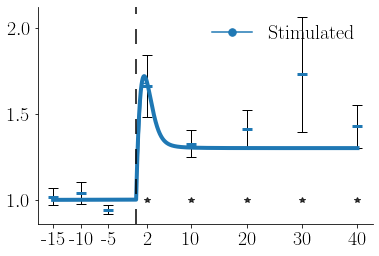

In [8]:
sDir = SpineDir+'Sham/'
Dir  = SpineDir+'Control/'
Dir  = [Dir,sDir]
Name = '1_pot'
PlotName = 'Test'
PlotSimpleCurve(Dir,Name,Type='stim',PlotColor='Control')


#### Figure 2c

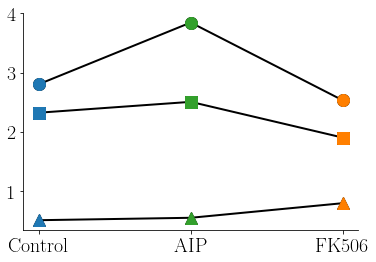

In [9]:
Dir = SpineDir+'Control/'
Name = '1_pot'
with open(Dir+Name+'.json', 'r') as fp: temp = json.load(fp)
nu1 = [temp['nu1']]
nu2 = [temp['nu2']]
P0 = [temp['P_init']]
for N in ['Calcineurin','CamKII_alt']:
    Dir = SpineDir+N+'/'
    Name = '1_'+N+'_nu'
    with open(Dir+Name+'.json', 'r') as fp: temp = json.load(fp)
    nu1.append(temp['nu1'])
    nu2.append(temp['nu2'])
    P0.append(temp['P_init'])

fig,ax = plt.subplots(1,1)
plt.plot(np.array(nu1)/np.array(P0),'o-',label=r'$\nu_1/P_0$',lw=0.5*lw,ms=3*lw,color='k')
plt.plot(np.array(nu2)/np.array(P0),'s-',label=r'$\nu_2/P_0$',lw=0.5*lw,ms=3*lw,color='k')
plt.plot(np.array(nu1)-np.array(nu2),'^-',label=r'$\nu_1-\nu_2$',lw=0.5*lw,ms=3*lw,color='k')

plt.plot(np.array(nu1[0])/np.array(P0[0]),'o',label=r'$\nu_1/P_0$',lw=lw,ms=3*lw,color=C[ColorDict['Control']])
plt.plot(np.array(nu2[0])/np.array(P0[0]),'s',lw=lw,ms=3*lw,color=C[ColorDict['Control']])
plt.plot(np.array(nu1[0])-np.array(nu2[0]),'^',lw=lw,ms=3*lw,color=C[ColorDict['Control']])

plt.plot(1,np.array(nu1[1])/np.array(P0[1]),'o',label=r'$\nu_1/P_0$',lw=lw,ms=3*lw,color=C[ColorDict['CamKII']])
plt.plot(1,np.array(nu2[1])/np.array(P0[1]),'s',lw=lw,ms=3*lw,color=C[ColorDict['CamKII']])
plt.plot(1,np.array(nu1[1])-np.array(nu2[1]),'^',lw=lw,ms=3*lw,color=C[ColorDict['CamKII']])

plt.plot(2,np.array(nu1[2])/np.array(P0[2]),'o',label=r'$\nu_1/P_0$',lw=lw,ms=3*lw,color=C[ColorDict['Calcineurin']])
plt.plot(2,np.array(nu2[2])/np.array(P0[2]),'s',lw=lw,ms=3*lw,color=C[ColorDict['Calcineurin']])
plt.plot(2,np.array(nu1[2])-np.array(nu2[2]),'^',lw=lw,ms=3*lw,color=C[ColorDict['Calcineurin']])
plt.xticks([0,1,2],[labelDict['Control'],labelDict['CamKII'],labelDict['Calcineurin']])

plt.xticks([0,1,2],[labelDict['Control'],labelDict['CamKII'],labelDict['Calcineurin']])
ax.tick_params(axis='both', which='major', labelsize=fs)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

#### Figure 2d

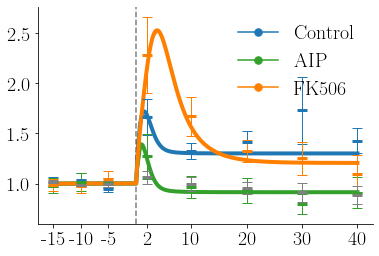

In [10]:
fig,ax=plt.subplots(1,1)

Dir = SpineDir+'Control/'

Name = '1_pot'
l1 = 'Control'
l2 = 'CamKII'
l3 = 'Calcineurin'
with open(Dir+Name+'.json', 'r') as fp: temp = json.load(fp)
CE = hp.ChemEquations(temp['C_init'],temp['P_init'],temp['a'],temp['b1'],temp['b2'],temp['c1'],temp['c2'],temp['nu1'],temp['nu2'])
    
TS = hp.TS_euler()

_,_,sSol = hp.ForwardSolve(TS,CE,dt,tpts)

ax.plot(tvec[::1000],sSol[::1000],color=C[ColorDict[l1]],ls='-',marker='.',label=labelDict[l1],ms=0.1)
tvec_t = np.insert(tvec,0,-15)
sSol = [1]+sSol



plt.plot(tvec_t,sSol,color=C[ColorDict[l1]],lw=lw)
    
plt.axvline(0,linestyle='--',color='k',alpha=0.5)

Dir2 = SpineDir+'CamKII_alt/'
Name = '1_CamKII_alt_nu'

with open(Dir2+Name+'.json', 'r') as fp: temp = json.load(fp)
CE = hp.ChemEquations(temp['C_init'],temp['P_init'],temp['a'],temp['b1'],temp['b2'],temp['c1'],temp['c2'],temp['nu1'],temp['nu2'])
    
TS = hp.TS_euler()

_,_,sSol = hp.ForwardSolve(TS,CE,dt,tpts)

ax.plot(tvec[::1000],sSol[::1000],color=C[ColorDict[l2]],ls='-',marker='.',label=labelDict[l2],ms=0.1)
tvec_t = np.insert(tvec,0,-15)
sSol = [1]+sSol


plt.plot(tvec_t,sSol,color=C[ColorDict[l2]],lw=lw)

Dir3 = SpineDir+'Calcineurin/'
Name = '1_Calcineurin_nu'

with open(Dir3+Name+'.json', 'r') as fp: temp = json.load(fp)
CE = hp.ChemEquations(temp['C_init'],temp['P_init'],temp['a'],temp['b1'],temp['b2'],temp['c1'],temp['c2'],temp['nu1'],temp['nu2'])
    
TS = hp.TS_euler()

_,_,sSol = hp.ForwardSolve(TS,CE,dt,tpts)
    
ax.plot(tvec[::1000],sSol[::1000],color=C[ColorDict[l3]],ls='-',marker='.',label=labelDict[l3],ms=0.1)
tvec_t = np.insert(tvec,0,-15)
sSol = [1]+sSol

plt.plot(tvec_t,sSol,color=C[ColorDict[l3]],lw=lw)

DirS = '/Users/maximilianeggl/Dropbox/PostDoc/HeteroPlast/heterosynaptic_project/NewCode/CA1_1Spine/Sham/'
lS = 'Sham'


PlotFitMultiCurve(Dir,Dir2,Dir3,DirS,'',ax,'stim',[l1,l2,l3,lS])


ax.legend(prop={'size': fs},markerscale=150,frameon=False)





#### Figure 2e

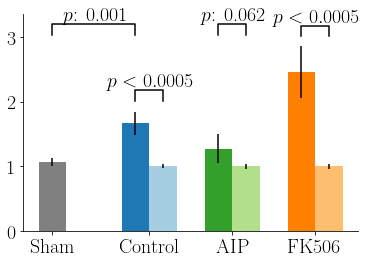

In [11]:
Stim = []
StimMean = []
StimErr = []
Stim_e = []
StimMean_e = []
StimErr_e = []
Stim_b = []
StimMean_b = []
StimErr_b = []
iS     = []
iS2     = []
col    = []
col2    = []
for i,N in enumerate(['Sham','Control','CamKII_alt','Calcineurin']):
    Dir = SpineDir+ N + '/'
    D1,A1,_ = ReadFiles(Dir)
    if(N=='Control' or N=='Calcineurin' ):
        A1 =  PreSortData(A1[D1==0],False)
    else:
        A1 = A1[D1==0]
        
    Stim.append(A1[:,3])
    StimMean.append(np.nanmean(A1,axis=0)[3])
    StimErr.append(stats.sem(A1,0,nan_policy='omit')[3])
    iS2.append(i*1.5)
    col.append(C[ColorDict[N]])
    if(not N=='Sham'):
        Stim.append(A1[:,:3].flatten())
        StimMean.append(np.nanmean(A1[:,:3].flatten(),axis=0))
        StimErr.append(stats.sem(A1[:,:3].flatten(),0,nan_policy='omit'))
        iS2.append(1.5*i+0.5)
        col.append(C[ColorDict[N]-1])
    Stim_e.append(A1[:,-1])
    StimMean_e.append(np.nanmean(A1,axis=0)[-1])
    StimErr_e.append(stats.sem(A1,0,nan_policy='omit')[-1])
    
    iS.append(i)
    col2.append(C[ColorDict[N]-1])

fig,ax = plt.subplots(1,1)
ax.bar(iS2,StimMean,yerr=StimErr,color = col,width=0.5)

plt.xticks([0,1.75,3.25,4.75],[labelDict['Sham'],labelDict['Control'],labelDict['CamKII'],labelDict['Calcineurin']])

h = barplot_annotate_brackets(5,6, stats.ttest_ind(Stim[5],Stim[6],permutations=10000,equal_var=True).pvalue, iS2, np.array(StimMean)+np.array(StimErr))
h = barplot_annotate_brackets(3,4, stats.ttest_ind(Stim[3],Stim[4],permutations=1000000,equal_var=True).pvalue, iS2, np.ones_like(StimMean)*h)
barplot_annotate_brackets(1,2, stats.ttest_ind(Stim[1],Stim[2],permutations=100000,equal_var=True).pvalue, iS2, np.array(StimMean)+np.array(StimErr))




i,j = 0,1
barplot_annotate_brackets(i, j,stats.ttest_ind(Stim[i],Stim[j],permutations=10000,equal_var=True).pvalue, iS2, np.ones_like(StimMean)*h)
ax.tick_params(axis='both', which='major', labelsize=fs)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)




#### Figure 2f

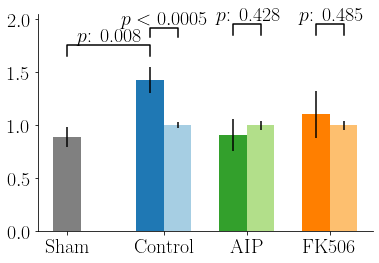

In [12]:
Stim = []
StimMean = []
StimErr = []
Stim_e = []
StimMean_e = []
StimErr_e = []
Stim_b = []
StimMean_b = []
StimErr_b = []
iS     = []
iS2     = []
col    = []
col2    = []
for i,N in enumerate(['Sham','Control','CamKII_alt','Calcineurin']):
    Dir = '/Users/maximilianeggl/Dropbox/PostDoc/HeteroPlast/heterosynaptic_project/NewCode/CA1_1Spine/'+ N + '/'
    D1,A1,_ = ReadFiles(Dir)
    if(N=='Control' or N=='Calcineurin' ):
        A1 =  PreSortData(A1[D1==0],False)
    else:
        A1 = A1[D1==0]
        
    Stim.append(A1[:,-1])
    StimMean.append(np.nanmean(A1,axis=0)[-1])
    StimErr.append(stats.sem(A1,0,nan_policy='omit')[-1])
    iS2.append(1.5*i)
    col.append(C[ColorDict[N]])
    if(not N=='Sham'):
        Stim.append(A1[:,:3].flatten())
        StimMean.append(np.nanmean(A1[:,:3].flatten(),axis=0))
        StimErr.append(stats.sem(A1[:,:3].flatten(),0,nan_policy='omit'))
        iS2.append(1.5*i+0.5)
        col.append(C[ColorDict[N]-1])
    Stim_e.append(A1[:,-1])
    StimMean_e.append(np.nanmean(A1,axis=0)[-1])
    StimErr_e.append(stats.sem(A1,0,nan_policy='omit')[-1])
    
    iS.append(i)
    col2.append(C[ColorDict[N]-1])

for i,S in enumerate(Stim):
    Stim[i] = S[~np.isnan(S)]
fig,ax = plt.subplots(1,1)
ax.bar(iS2,StimMean,yerr=StimErr,color = col,width=0.5)

plt.xticks([0,1.75,3.25,4.75],[labelDict['Sham'],labelDict['Control'],labelDict['CamKII'],labelDict['Calcineurin']])
h = barplot_annotate_brackets(1,2, stats.ttest_ind(Stim[1],Stim[2],permutations=10000,equal_var=True).pvalue, iS2, np.array(StimMean)+np.array(StimErr)+0.2)

h = barplot_annotate_brackets(5,6, stats.ttest_ind(Stim[5],Stim[6],permutations=10000,equal_var=True).pvalue, iS2, np.ones_like(StimMean)*h)
h = barplot_annotate_brackets(3,4,stats.ttest_ind(Stim[3],Stim[4],permutations=10000,equal_var=True).pvalue, iS2, np.ones_like(StimMean)*h)

i,j = 0,1
barplot_annotate_brackets(i, j,stats.ttest_ind(Stim[i],Stim[j],permutations=10000,equal_var=True).pvalue, iS2, np.ones_like(StimMean)*h-0.2)

ax.tick_params(axis='both', which='major', labelsize=fs)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)



#### Figure 2g

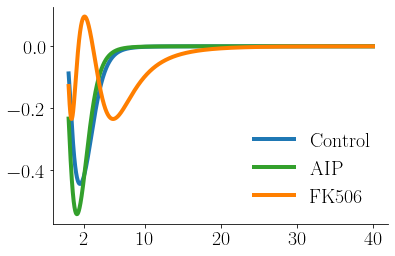

In [13]:
fig1,ax1 = plt.subplots()
Dir = SpineDir+'Control/'
Name = '1_pot'
PlotSimulationFP(Dir,Name,ax=ax1,Col=C[ColorDict['Control']],lab='Control')
Dir = SpineDir+'CamKII_alt/'
Name = '1_CamKII_alt_nu'
PlotSimulationFP(Dir,Name,ax=ax1,Col=C[ColorDict['CamKII']],lab='AIP')
Dir = SpineDir+'Calcineurin/'
Name = '1_Calcineurin_nu'
PlotSimulationFP(Dir,Name,ax=ax1,Col=C[ColorDict['Calcineurin']],lab='FK506')

plt.xticks(times[3:])
ax1.spines["right"].set_visible(False)
ax1.spines["top"].set_visible(False)

#### Figure 2h

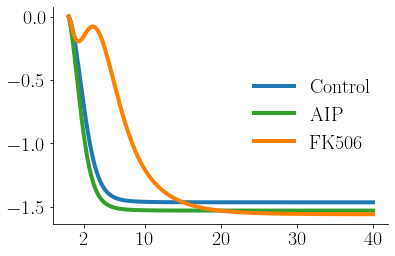

In [14]:
fig1,ax1 = plt.subplots()
Dir = SpineDir+'Control/'
Name = '1_pot'
PlotSimulationFPCum(Dir,Name,ax=ax1,Col=C[ColorDict['Control']],lab='Control')
Dir = SpineDir+'CamKII_alt/'
Name = '1_CamKII_alt_nu'
PlotSimulationFPCum(Dir,Name,ax=ax1,Col=C[ColorDict['CamKII']],lab='AIP')
Dir = SpineDir+'Calcineurin/'
Name = '1_Calcineurin_nu'
PlotSimulationFPCum(Dir,Name,ax=ax1,Col=C[ColorDict['Calcineurin']],lab='FK506')

plt.xticks(times[3:])
ax1.spines["right"].set_visible(False)
ax1.spines["top"].set_visible(False)

### Figure 3

In [15]:
SpineDir = BaseDir+'CA1_3Spine/'

#### Figure 3b

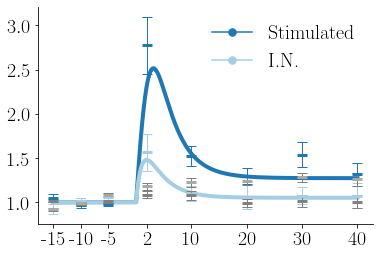

In [16]:
fig,ax=plt.subplots(1,1)

Dir = SpineDir+'Control/'

Name = '3_pot'

with open(Dir+Name+'.json', 'r') as fp: temp = json.load(fp)
CE = hp.ChemEquations(temp['C_init'],temp['P_init'],temp['a'],temp['b1'],temp['b2'],temp['c1'],temp['c2'],temp['nu1'],temp['nu2'])
    
TS = hp.TS_euler()

_,_,sSol = hp.ForwardSolve(TS,CE,dt,tpts)
l1 = 'Control'
lS = 'Sham'
ax.plot(tvec[::1000],sSol[::1000],color=C[ColorDict[l1]],ls='-',marker='.',label='Stimulated',ms=0.1)
tvec_t = np.insert(tvec,0,-15)
sSol = [1]+sSol
plt.plot(tvec_t,sSol,color=C[ColorDict[l1]],lw=lw)

Name = '3_clust'

with open(Dir+Name+'.json', 'r') as fp: temp = json.load(fp)
CE = hp.ChemEquations(temp['C_init'],temp['P_init'],temp['a'],temp['b1'],temp['b2'],temp['c1'],temp['c2'],temp['nu1'],temp['nu2'])
    
TS = hp.TS_euler()

_,_,sSol = hp.ForwardSolve(TS,CE,dt,tpts)

ax.plot(tvec[::1000],sSol[::1000],color=C[ColorDict[l1]-1],ls='-',marker='.',label='I.N.',ms=0.1)
tvec_t = np.insert(tvec,0,-15)
sSol = [1]+sSol
    
plt.plot(tvec_t,sSol,color=C[ColorDict[l1]-1],lw=lw)

DirS = SpineDir+'Sham/'
PlotStimIn(Dir,DirS,'',ax,[l1,lS])

ax.legend(prop={'size': fs},markerscale=150,frameon=False)
plt.show()






#### Figure 3c

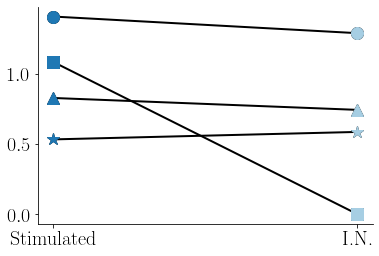

In [17]:
Dir = SpineDir+'Control/'
Name = '3_pot'
with open(Dir+Name+'.json', 'r') as fp: temp = json.load(fp)
nu1 = [temp['nu1']]
nu2 = [temp['nu2']]
P0 = [temp['P_init']]
C0 = [temp['C_init']]

Name = '3_clust'
with open(Dir+Name+'.json', 'r') as fp: temp = json.load(fp)
nu1.append(temp['nu1'])
nu2.append(temp['nu2'])
P0.append(temp['P_init'])
C0.append(temp['C_init'])

col = np.zeros((8,3))
l1 = ColorDict['Sham']
l2 = ColorDict['Control']

b = np.linspace(C[l2],C[l2-1],4).tolist()
fig,ax = plt.subplots(1,1)
plt.plot(np.array(nu1),'o-',label=r'$\nu_1$',lw=0.5*lw,ms=3*lw,color='k')
plt.plot(np.array(nu2),'*-',label=r'$\nu_2$',lw=0.5*lw,ms=3*lw,color='k')
plt.plot(np.array(P0),'s-',label=r'$P_0$',lw=0.5*lw,ms=3*lw,color='k')
plt.plot(np.array(C0),'^-',label=r'$C_0$',lw=0.5*lw,ms=3*lw,color='k')
#leg = plt.legend(prop={'size': fs},loc=1)#, bbox_to_anchor=(0.5,0.9))

plt.plot(np.array(nu1[0]),'o',lw=0.5*lw,ms=3*lw,color=C[ColorDict['Control']])
plt.plot(np.array(nu2[0]),'*',lw=0.5*lw,ms=3*lw,color=C[ColorDict['Control']])
plt.plot(np.array(P0[0]),'s',lw=0.5*lw,ms=3*lw,color=C[ColorDict['Control']])
plt.plot(np.array(C0[0]),'^',lw=0.5*lw,ms=3*lw,color=C[ColorDict['Control']])

plt.plot(1,np.array(nu1[1]),'o',lw=0.5*lw,ms=3*lw,color=C[ColorDict['Control']-1])
plt.plot(1,np.array(nu2[1]),'*',lw=0.5*lw,ms=3*lw,color=C[ColorDict['Control']-1])
plt.plot(1,np.array(P0[1]),'s',lw=0.5*lw,ms=3*lw,color=C[ColorDict['Control']-1])
plt.plot(1,np.array(C0[1]),'^',lw=0.5*lw,ms=3*lw,color=C[ColorDict['Control']-1])

plt.xticks([0,1],['Stimulated','I.N.'])
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

ax.tick_params(axis='both', which='major', labelsize=fs)

#### Figure 3d

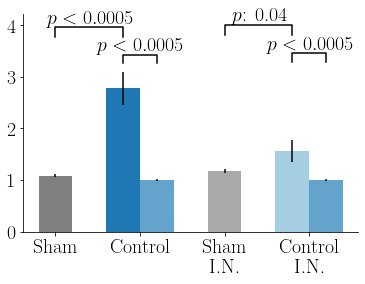

In [18]:
h = 0
Stim = []
StimMean = []
StimErr = []
Stim_e = []
StimMean_e = []
StimErr_e = []
iS     = []
col    = []
for i,N in enumerate(['Sham','Control']):
    Dir = SpineDir+ N + '/'
    D1,A1,_ = ReadFiles(Dir)
    if(N=='Control'):
        a1 =  PreSortData(A1[D1==0],False)
    else:
        a1 = A1[D1==0]
    col.append(C[ColorDict[N]])
    Stim.append(a1[:,3])
    StimMean.append(np.nanmean(a1,axis=0)[3])
    StimErr.append(stats.sem(a1,0,nan_policy='omit')[3])
    iS.append(i)
    if(N=='Control'):
        Stim.append(a1[:,:3].flatten())
        StimMean.append(np.nanmean(a1[:,:3].flatten(),axis=0))
        StimErr.append(stats.sem(a1[:,:3].flatten(),0,nan_policy='omit'))
        iS.append(i+0.5)
        col.append(0.5*C[ColorDict[N]]+0.5*C[ColorDict[N]-1])
    
for i,N in enumerate(['Sham','Control']):
    Dir = SpineDir+ N + '/'
    D1,A1,_ = ReadFiles(Dir)
    a2 =  A1[D1<0]
    col.append(C[ColorDict[N]-1])
    
    Stim.append(a2[:,3])
    StimMean.append(np.nanmean(a2,axis=0)[3])
    StimErr.append(stats.sem(a2,0,nan_policy='omit')[3])
    iS.append(1*i+2.5)
    if(N=='Control'):
        Stim.append(a1[:,:3].flatten())
        StimMean.append(np.nanmean(a1[:,:3].flatten(),axis=0))
        StimErr.append(stats.sem(a1[:,:3].flatten(),0,nan_policy='omit'))
        iS.append(i+3.0)
        col.append(0.5*C[ColorDict[N]]+0.5*C[ColorDict[N]-1])


fig,ax = plt.subplots(1,1)
ax.bar(iS,StimMean,yerr=StimErr,color = col,width=0.5)

h = barplot_annotate_brackets(1,2, stats.ttest_ind(Stim[1],Stim[2],nan_policy='omit',permutations=1000).pvalue, iS, np.array(StimMean)+np.array(StimErr))
i,j = 4,5
barplot_annotate_brackets(i,j, stats.ttest_ind(Stim[i],Stim[j],nan_policy='omit',permutations=1000).pvalue, iS, np.ones_like(StimMean)*h)


h = barplot_annotate_brackets(0,1, stats.ttest_ind(Stim[0],Stim[1],nan_policy='omit',permutations=1000).pvalue, iS, np.array(StimMean)+np.array(StimErr)+0.5)
i,j = 3,4
barplot_annotate_brackets(i,j, stats.ttest_ind(Stim[i],Stim[j],nan_policy='omit',permutations=1000).pvalue, iS, np.ones_like(StimMean)*h)

ax.tick_params(axis='both', which='major', labelsize=fs)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

plt.xticks([0,1.25,2.5,3.75],[labelDict['Sham'],labelDict['Control'],labelDict['Sham']+'\n I.N.',labelDict['Control']+'\n I.N.'])

plt.show()

#### Figure 3e

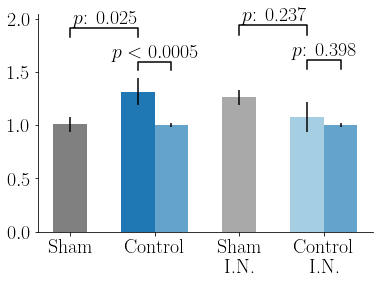

In [19]:
h = 0
Stim = []
StimMean = []
StimErr = []
Stim_e = []
StimMean_e = []
StimErr_e = []
iS     = []
col    = []
for i,N in enumerate(['Sham','Control']):
    Dir = SpineDir+ N + '/'
    D1,A1,_ = ReadFiles(Dir)
    if(N=='Control'):
        a1 =  PreSortData(A1[D1==0],False)
    else:
        a1 = A1[D1==0]
    col.append(C[ColorDict[N]])
    Stim.append(a1[:,-1])
    StimMean.append(np.nanmean(a1,axis=0)[-1])
    StimErr.append(stats.sem(a1,0,nan_policy='omit')[-1])
    iS.append(i)
    if(N=='Control'):
        Stim.append(a1[:,:3].flatten())
        StimMean.append(np.nanmean(a1[:,:3].flatten(),axis=0))
        StimErr.append(stats.sem(a1[:,:3].flatten(),0,nan_policy='omit'))
        iS.append(i+0.5)
        col.append(0.5*C[ColorDict[N]]+0.5*C[ColorDict[N]-1])
    
for i,N in enumerate(['Sham','Control']):
    Dir = SpineDir+ N + '/'
    D1,A1,_ = ReadFiles(Dir)
    a2 =  A1[D1<0]
    col.append(C[ColorDict[N]-1])
    
    Stim.append(a2[:,-1])
    StimMean.append(np.nanmean(a2,axis=0)[-1])
    StimErr.append(stats.sem(a2,0,nan_policy='omit')[-1])
    iS.append(1*i+2.5)
    if(N=='Control'):
        Stim.append(a1[:,:3].flatten())
        StimMean.append(np.nanmean(a1[:,:3].flatten(),axis=0))
        StimErr.append(stats.sem(a1[:,:3].flatten(),0,nan_policy='omit'))
        iS.append(i+3.0)
        col.append(0.5*C[ColorDict[N]]+0.5*C[ColorDict[N]-1])


fig,ax = plt.subplots(1,1)
ax.bar(iS,StimMean,yerr=StimErr,color = col,width=0.5)

h = barplot_annotate_brackets(1,2, stats.ttest_ind(Stim[1],Stim[2],nan_policy='omit',permutations=1000).pvalue, iS, np.array(StimMean)+np.array(StimErr))
i,j = 4,5
barplot_annotate_brackets(i,j, stats.ttest_ind(Stim[i],Stim[j],nan_policy='omit',permutations=1000).pvalue, iS, np.ones_like(StimMean)*h)


h = barplot_annotate_brackets(0,1, stats.ttest_ind(Stim[0],Stim[1],nan_policy='omit',permutations=1000).pvalue, iS, np.array(StimMean)+np.array(StimErr)+0.3)
i,j = 3,4
barplot_annotate_brackets(i,j, stats.ttest_ind(Stim[i],Stim[j],nan_policy='omit',permutations=1000).pvalue, iS, np.ones_like(StimMean)*h)


ax.tick_params(axis='both', which='major', labelsize=fs)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

plt.xticks([0,1.25,2.5,3.75],[labelDict['Sham'],labelDict['Control'],labelDict['Sham']+'\n I.N.',labelDict['Control']+'\n I.N.'])

plt.show()

#### Figure 3f

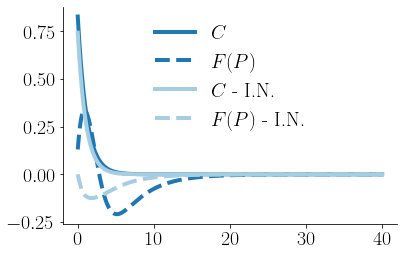

In [20]:
fig1,ax1 = plt.subplots()
Dir = SpineDir+'Control/'
Name = '3_pot'
PlotSimulationCFP(Dir,Name,ax1)
Name = '3_clust'
PlotSimulationCFP(Dir,Name,Col=C[ColorDict['Control']-1],ax=ax1,Type='Clust')

ax1.spines["right"].set_visible(False)
ax1.spines["top"].set_visible(False)





### Figure 4

In [21]:
SpineDir = BaseDir+'CA1_7Spine/'

#### Figure 4b

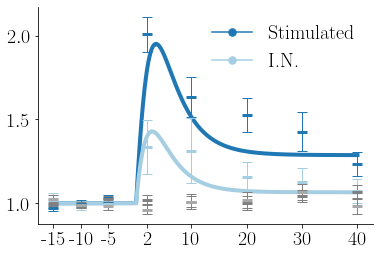

In [22]:
fig,ax=plt.subplots(1,1)

Dir = SpineDir+'Control/'

Name = '7_pot'
l1 = 'Control'
with open(Dir+Name+'.json', 'r') as fp: temp = json.load(fp)
CE = hp.ChemEquations(temp['C_init'],temp['P_init'],temp['a'],temp['b1'],temp['b2'],temp['c1'],temp['c2'],temp['nu1'],temp['nu2'])
    
TS = hp.TS_euler()

_,_,sSol = hp.ForwardSolve(TS,CE,dt,tpts)
ax.plot(tvec[::1000],sSol[::1000],color=C[ColorDict[l1]],ls='-',marker='.',label='Stimulated',ms=0.1)    
tvec_t = np.insert(tvec,0,-15)
sSol = [1]+sSol

l1 = 'Control'
plt.plot(tvec_t,sSol,color=C[ColorDict[l1]],lw=lw)

Name = '7_clust'

with open(Dir+Name+'.json', 'r') as fp: temp = json.load(fp)
CE = hp.ChemEquations(temp['C_init'],temp['P_init'],temp['a'],temp['b1'],temp['b2'],temp['c1'],temp['c2'],temp['nu1'],temp['nu2'])
    
TS = hp.TS_euler()

_,_,sSol = hp.ForwardSolve(TS,CE,dt,tpts)

ax.plot(tvec[::1000],sSol[::1000],color=C[ColorDict[l1]-1],ls='-',marker='.',label='I.N.',ms=0.1)

tvec_t = np.insert(tvec,0,-15)
sSol = [1]+sSol

l2 = 'Control'


    
plt.plot(tvec_t,sSol,color=C[ColorDict[l1]-1],lw=lw)


DirS = SpineDir+'Sham/'
lS = 'Sham'


PlotStimIn(Dir,DirS,'',ax,[l1,lS])

ax.legend(prop={'size': fs},markerscale=150,frameon=False)







#### Figure 4c

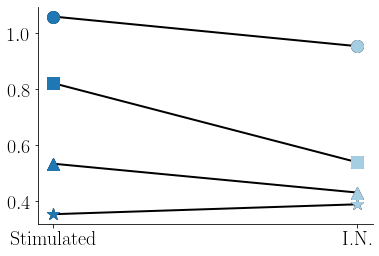

In [23]:
Dir = SpineDir+'Control/'
Name = '7_pot'
with open(Dir+Name+'.json', 'r') as fp: temp = json.load(fp)
nu1 = [temp['nu1']]
nu2 = [temp['nu2']]
P0 = [temp['P_init']]
C0 = [temp['C_init']]
Dir = SpineDir+'Control/'
Name = '7_clust'
with open(Dir+Name+'.json', 'r') as fp: temp = json.load(fp)
nu1.append(temp['nu1'])
nu2.append(temp['nu2'])
P0.append(temp['P_init'])
C0.append(temp['C_init'])

col = np.zeros((8,3))
l1 = ColorDict['Sham']
l2 = ColorDict['Control']

b = np.linspace(C[l2],C[l2-1],4).tolist()
fig,ax = plt.subplots(1,1)
plt.plot(np.array(nu1),'o-',label=r'$\nu_1$',lw=0.5*lw,ms=3*lw,color='k')
plt.plot(np.array(nu2),'*-',label=r'$\nu_2$',lw=0.5*lw,ms=3*lw,color='k')
plt.plot(np.array(P0),'s-',label=r'$P_0$',lw=0.5*lw,ms=3*lw,color='k')
plt.plot(np.array(C0),'^-',label=r'$C_0$',lw=0.5*lw,ms=3*lw,color='k')
#leg = plt.legend(prop={'size': fs},loc=1)#, bbox_to_anchor=(0.5,0.9))

plt.plot(np.array(nu1[0]),'o',lw=0.5*lw,ms=3*lw,color=C[ColorDict['Control']])
plt.plot(np.array(nu2[0]),'*',lw=0.5*lw,ms=3*lw,color=C[ColorDict['Control']])
plt.plot(np.array(P0[0]),'s',lw=0.5*lw,ms=3*lw,color=C[ColorDict['Control']])
plt.plot(np.array(C0[0]),'^',lw=0.5*lw,ms=3*lw,color=C[ColorDict['Control']])

plt.plot(1,np.array(nu1[1]),'o',lw=0.5*lw,ms=3*lw,color=C[ColorDict['Control']-1])
plt.plot(1,np.array(nu2[1]),'*',lw=0.5*lw,ms=3*lw,color=C[ColorDict['Control']-1])
plt.plot(1,np.array(P0[1]),'s',lw=0.5*lw,ms=3*lw,color=C[ColorDict['Control']-1])
plt.plot(1,np.array(C0[1]),'^',lw=0.5*lw,ms=3*lw,color=C[ColorDict['Control']-1])
#leg= plt.legend(prop={'size': fs},loc=9)
#leg.get_frame().set_linewidth(0.0)
plt.xticks([0,1],['Stimulated','I.N.'])
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.tick_params(axis='both', which='major', labelsize=fs)

#### Figure 4d

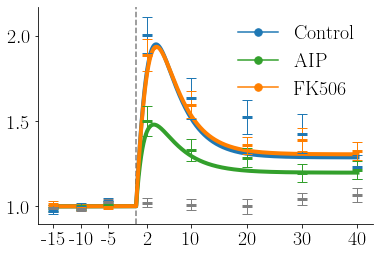

In [24]:
fig,ax=plt.subplots(1,1)

Dir = SpineDir+'Control/'

Name = '7_pot'

with open(Dir+Name+'.json', 'r') as fp: temp = json.load(fp)
CE = hp.ChemEquations(temp['C_init'],temp['P_init'],temp['a'],temp['b1'],temp['b2'],temp['c1'],temp['c2'],temp['nu1'],temp['nu2'])
    
TS = hp.TS_euler()

_,_,sSol = hp.ForwardSolve(TS,CE,dt,tpts)

l1 = 'Control'
l2 = 'CamKII'
l3 = 'Calcineurin'
ax.plot(tvec[::1000],sSol[::1000],color=C[ColorDict[l1]],ls='-',marker='.',label=labelDict[l1],ms=0.1)


tvec_t = np.insert(tvec,0,-15)
sSol = [1]+sSol

plt.plot(tvec_t,sSol,color=C[ColorDict[l1]],lw=lw)
    
plt.axvline(0,linestyle='--',color='k',alpha=0.5)

Dir2 = '/Users/maximilianeggl/Dropbox/PostDoc/HeteroPlast/heterosynaptic_project/NewCode/CA1_7Spine/CamKII/'
Name = '7_CamKII_nu'

with open(Dir2+Name+'.json', 'r') as fp: temp = json.load(fp)
CE = hp.ChemEquations(temp['C_init'],temp['P_init'],temp['a'],temp['b1'],temp['b2'],temp['c1'],temp['c2'],temp['nu1'],temp['nu2'])
    
TS = hp.TS_euler()

_,_,sSol = hp.ForwardSolve(TS,CE,dt,tpts)
    
ax.plot(tvec[::1000],sSol[::1000],color=C[ColorDict[l2]],ls='-',marker='.',label=labelDict[l2],ms=0.1)
tvec_t = np.insert(tvec,0,-15)
sSol = [1]+sSol


plt.plot(tvec_t,sSol,color=C[ColorDict[l2]],lw=lw)

Dir3 = '/Users/maximilianeggl/Dropbox/PostDoc/HeteroPlast/heterosynaptic_project/NewCode/CA1_7Spine/Calcineurin/'
Name = '7_Calcineurin_nu'

with open(Dir3+Name+'.json', 'r') as fp: temp = json.load(fp)
CE = hp.ChemEquations(temp['C_init'],temp['P_init'],temp['a'],temp['b1'],temp['b2'],temp['c1'],temp['c2'],temp['nu1'],temp['nu2'])
    
TS = hp.TS_euler()

_,_,sSol = hp.ForwardSolve(TS,CE,dt,tpts)

ax.plot(tvec[::1000],sSol[::1000],color=C[ColorDict[l3]],ls='-',marker='.',label=labelDict[l3],ms=0.1)
tvec_t = np.insert(tvec,0,-15)
sSol = [1]+sSol


plt.plot(tvec_t,sSol,color=C[ColorDict[l3]],lw=lw)

DirS = '/Users/maximilianeggl/Dropbox/PostDoc/HeteroPlast/heterosynaptic_project/NewCode/CA1_7Spine/Sham/'
lS = 'Sham'


PlotFitMultiCurve(Dir,Dir2,Dir3,DirS,'',ax,'stim',[l1,l2,l3,lS])
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

    
ax.legend(prop={'size': fs},markerscale=150,frameon=False)






#### Figure 4e

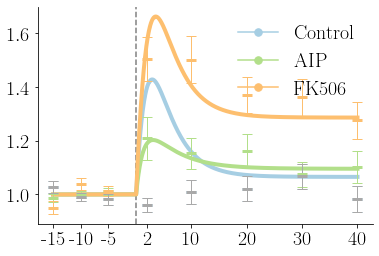

In [25]:
fig,ax=plt.subplots(1,1)

Dir = SpineDir+'Control/'

Name = '7_clust'

with open(Dir+Name+'.json', 'r') as fp: temp = json.load(fp)
CE = hp.ChemEquations(temp['C_init'],temp['P_init'],temp['a'],temp['b1'],temp['b2'],temp['c1'],temp['c2'],temp['nu1'],temp['nu2'])
    
TS = hp.TS_euler()

_,_,sSol = hp.ForwardSolve(TS,CE,dt,tpts)

l1 = 'Control'
l2 = 'CamKII'
l3 = 'Calcineurin'

ax.plot(tvec[::1000],sSol[::1000],color=C[ColorDict[l1]-1],ls='-',marker='.',label=labelDict[l1],ms=0.1)


tvec_t = np.insert(tvec,0,-15)
sSol = [1]+sSol


plt.plot(tvec_t,sSol,color=C[ColorDict[l1]-1],lw=lw)
    
plt.axvline(0,linestyle='--',color='k',alpha=0.5)

Dir = SpineDir+'CamKII/'
Name = '7_CamKII_nu_clust'

with open(Dir2+Name+'.json', 'r') as fp: temp = json.load(fp)
CE = hp.ChemEquations(temp['C_init'],temp['P_init'],temp['a'],temp['b1'],temp['b2'],temp['c1'],temp['c2'],temp['nu1'],temp['nu2'])
    
TS = hp.TS_euler()

_,_,sSol = hp.ForwardSolve(TS,CE,dt,tpts)

ax.plot(tvec[::1000],sSol[::1000],color=C[ColorDict[l2]-1],ls='-',marker='.',label=labelDict[l2],ms=0.1)

tvec_t = np.insert(tvec,0,-15)
sSol = [1]+sSol


plt.plot(tvec_t,sSol,color=C[ColorDict[l2]-1],lw=lw)

Dir = SpineDir+'Calcineurin/'
Name = '7_Calcineurin_nu_clust'

with open(Dir3+Name+'.json', 'r') as fp: temp = json.load(fp)
CE = hp.ChemEquations(temp['C_init'],temp['P_init'],temp['a'],temp['b1'],temp['b2'],temp['c1'],temp['c2'],temp['nu1'],temp['nu2'])
    
TS = hp.TS_euler()

_,_,sSol = hp.ForwardSolve(TS,CE,dt,tpts)

ax.plot(tvec[::1000],sSol[::1000],color=C[ColorDict[l3]-1],ls='-',marker='.',label=labelDict[l3],ms=0.1)
tvec_t = np.insert(tvec,0,-15)
sSol = [1]+sSol



plt.plot(tvec_t,sSol,color=C[ColorDict[l3]-1],lw=lw)

Dir = SpineDir+'Sham/'
lS = 'Sham'


PlotFitMultiCurve(Dir,Dir2,Dir3,DirS,'',ax,'clust',[l1,l2,l3,lS])


    
ax.legend(prop={'size': fs},markerscale=150,frameon=False)







#### Figure 4f

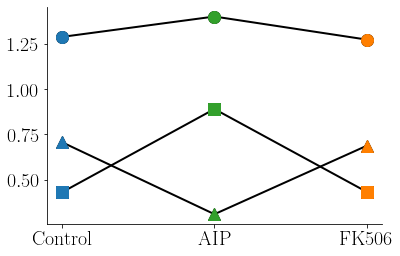

In [26]:
Dir = SpineDir+'Control/'
Name = '7_pot'
with open(Dir+Name+'.json', 'r') as fp: temp = json.load(fp)
nu1 = [temp['nu1']]
nu2 = [temp['nu2']]
P0 = [temp['P_init']]
for N in ['CamKII','Calcineurin']:
    Dir = SpineDir+N+'/'
    Name = '7_'+N+'_nu'
    with open(Dir+Name+'.json', 'r') as fp: temp = json.load(fp)
    nu1.append(temp['nu1'])
    nu2.append(temp['nu2'])
    P0.append(temp['P_init'])

fig,ax = plt.subplots(1,1)
plt.plot(np.array(nu1)/np.array(P0),'o-',label=r'$\nu_1/P_0$',lw=0.5*lw,ms=3*lw,color='k')
plt.plot(np.array(nu2)/np.array(P0),'s-',label=r'$\nu_2/P_0$',lw=0.5*lw,ms=3*lw,color='k')
plt.plot(np.array(nu1)-np.array(nu2),'^-',label=r'$\nu_1-\nu_2$',lw=0.5*lw,ms=3*lw,color='k')
#leg = plt.legend(prop={'size': fs},loc=1, bbox_to_anchor=(0.5,0.9))
plt.plot(np.array(nu1[0])/np.array(P0[0]),'o',label=r'$\nu_1/P_0$',lw=lw,ms=3*lw,color=C[ColorDict['Control']])
plt.plot(np.array(nu2[0])/np.array(P0[0]),'s',lw=lw,ms=3*lw,color=C[ColorDict['Control']])
plt.plot(np.array(nu1[0])-np.array(nu2[0]),'^',lw=lw,ms=3*lw,color=C[ColorDict['Control']])

plt.plot(1,np.array(nu1[1])/np.array(P0[1]),'o',label=r'$\nu_1/P_0$',lw=lw,ms=3*lw,color=C[ColorDict['CamKII']])
plt.plot(1,np.array(nu2[1])/np.array(P0[1]),'s',lw=lw,ms=3*lw,color=C[ColorDict['CamKII']])
plt.plot(1,np.array(nu1[1])-np.array(nu2[1]),'^',lw=lw,ms=3*lw,color=C[ColorDict['CamKII']])

plt.plot(2,np.array(nu1[2])/np.array(P0[2]),'o',label=r'$\nu_1/P_0$',lw=lw,ms=3*lw,color=C[ColorDict['Calcineurin']])
plt.plot(2,np.array(nu2[2])/np.array(P0[2]),'s',lw=lw,ms=3*lw,color=C[ColorDict['Calcineurin']])
plt.plot(2,np.array(nu1[2])-np.array(nu2[2]),'^',lw=lw,ms=3*lw,color=C[ColorDict['Calcineurin']])
plt.xticks([0,1,2],[labelDict['Control'],labelDict['CamKII'],labelDict['Calcineurin']])

#plt.yticks([])


#leg.get_frame().set_linewidth(0.0)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.tick_params(axis='both', which='major', labelsize=fs)

#### Figure 4g

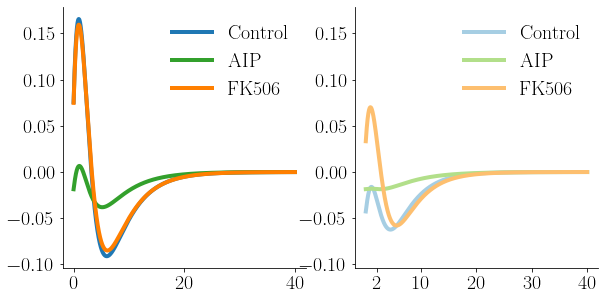

In [27]:
Na = ['Control','CamKII','Calcineurin']
fig,ax = plt.subplots(1,2,figsize=(9.6,4.8 ))
ax1 =ax[0]
Dir = SpineDir+'Control/'
Name = '7_pot'
PlotSimulationFP(Dir,Name,ax=ax1,Col=C[ColorDict['Control']],lab='Control')
Dir = SpineDir+'CamKII/'
Name = '7_CamKII_nu'
PlotSimulationFP(Dir,Name,ax=ax1,Col=C[ColorDict['CamKII']],lab='AIP')
Dir = SpineDir+'Calcineurin/'
Name = '7_Calcineurin_nu'
PlotSimulationFP(Dir,Name,ax=ax1,Col=C[ColorDict['Calcineurin']],lab='FK506')

plt.xticks(times[3:])
ax1.spines["right"].set_visible(False)
ax1.spines["top"].set_visible(False)
y_min,y_max = ax1.get_ylim()
ax1 =ax[1]
Dir = SpineDir+'Control/'
Name = '7_clust'
PlotSimulationFP(Dir,Name,ax=ax1,Col=C[ColorDict['Control']-1],lab='Control')

Dir = SpineDir+'CamKII/'
Name = '7_CamKII_nu'
Name = Name+'_clust'
PlotSimulationFP(Dir,Name,ax=ax1,Col=C[ColorDict['CamKII']-1],lab='AIP')
Dir = SpineDir+'Calcineurin/'
Name = '7_Calcineurin_nu'
Name = Name+'_clust'
PlotSimulationFP(Dir,Name,ax=ax1,Col=C[ColorDict['Calcineurin']-1],lab='FK506')

plt.xticks(times[3:])
ax1.set_ylim([y_min,y_max])
ax1.spines["right"].set_visible(False)
ax1.spines["top"].set_visible(False)

#### Figure 4h

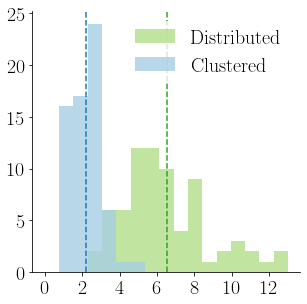

In [28]:
Dir = SpineDir+'Distributed/'

A1S,D1S,CS1S,SD1S =  ReadFilesSep(Dir)

Dir = SpineDir+'Control/'

A2S,D2S,CS2S,SD2S =  ReadFilesSep(Dir)

fig,ax = plt.subplots(figsize=(4.8,4.8))
plt.hist(np.hstack(SD1S)*0.066,np.linspace(0,13,18),alpha=0.8,rwidth=1.0,color=C[2],label='Distributed')
plt.axvline(np.hstack(SD1S).mean()*0.066,color=C[3],ls='--')

plt.hist(np.hstack(SD2S)*0.066,np.linspace(0,13,18),alpha=0.8,color=C[0],label='Clustered')
plt.axvline(np.hstack(SD2S).mean()*0.066,color=C[1],ls='--')

plt.xticks(np.linspace(0,12,7))
leg = ax.legend(prop={'size': 20}) 
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

leg.get_frame().set_linewidth(0.0)

#### Figure 4i

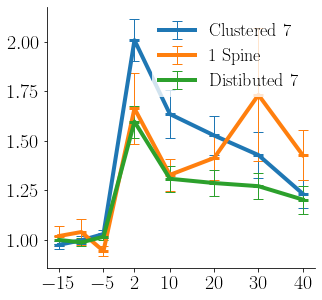

In [29]:
Dir = SpineDir+'Distributed/'
D1,A1,_ = ReadFiles(Dir)

A1 = PreSortData(A1[D1==0],False).T

Dir = SpineDir+'Control/'
D2,A2,_ = ReadFiles(Dir)

A2 = PreSortData(A2[D2==0],False).T

Dir =BaseDir+'/CA1_1Spine/Control/'
D3,A3,_ = ReadFiles(Dir)

A3 = PreSortData(A3[D3==0],False).T

tSig1 = np.array([0.05>stats.ttest_ind(d1,d2,nan_policy='omit',equal_var=True).pvalue for d1,d2 in zip(A1,A2)])
tSig2 = np.array([0.05>stats.ttest_ind(d1,d2,nan_policy='omit',equal_var=True).pvalue for d1,d2 in zip(A1,A3)])
tSig3 = np.array([0.05>stats.ttest_ind(d1,d2,nan_policy='omit',equal_var=True).pvalue for d1,d2 in zip(A2,A3)])

fig,ax = plt.subplots(figsize=(4.8,4.8))
_,caps,_ = plt.errorbar(x=times,y=np.nanmean(A2.T,axis=0),yerr=stats.sem(A2.T,0,nan_policy='omit'),label='Clustered 7',
                          capsize=5,marker='_',elinewidth=1,ms=10,mew=3,capthick=1,lw=4)
for cap in caps:
    cap.set_markeredgewidth(1)

_,caps,_ = plt.errorbar(x=times,y=np.nanmean(A3.T,axis=0),yerr=stats.sem(A3.T,0,nan_policy='omit'),label='1 Spine',
                          capsize=5,marker='_',elinewidth=1,ms=10,mew=3,capthick=1,lw=4)
for cap in caps:
    cap.set_markeredgewidth(1)
_,caps,_ = plt.errorbar(x=times,y=np.nanmean(A1.T,axis=0),yerr=stats.sem(A1.T,0,nan_policy='omit'),label='Distibuted 7',
             capsize=5,marker='_',elinewidth=1,ms=10,mew=3,capthick=1,lw=4)
for cap in caps:
    cap.set_markeredgewidth(1)

plt.xticks([-15,-5] + times[3:])
leg = ax.legend(prop={'size': 18},loc=1) 
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

leg.get_frame().set_linewidth(0.0)

### Figure 5

In [30]:
SpineDir = BaseDir+'CA1_15Spine/'

#### Figure 5b

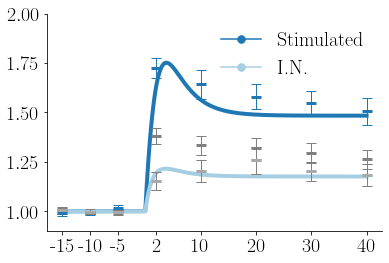

In [31]:
fig,ax=plt.subplots(1,1)

Dir = SpineDir+'Control/'

Name = '15_pot'
l1 = 'Control'

l2 = 'Control'
lS = 'Sham'

with open(Dir+Name+'.json', 'r') as fp: temp = json.load(fp)
CE = hp.ChemEquations(temp['C_init'],temp['P_init'],temp['a'],temp['b1'],temp['b2'],temp['c1'],temp['c2'],temp['nu1'],temp['nu2'])
    
TS = hp.TS_euler()

_,_,sSol = hp.ForwardSolve(TS,CE,dt,tpts)
ax.plot(tvec[::1000],sSol[::1000],color=C[ColorDict[l1]],ls='-',marker='.',label='Stimulated',ms=0.1)

    
tvec_t = np.insert(tvec,0,-15)
sSol = [1]+sSol


plt.plot(tvec_t,sSol,color=C[ColorDict[l1]],lw=lw)

Name = '15_clust'

with open(Dir+Name+'.json', 'r') as fp: temp = json.load(fp)
CE = hp.ChemEquations(temp['C_init'],temp['P_init'],temp['a'],temp['b1'],temp['b2'],temp['c1'],temp['c2'],temp['nu1'],temp['nu2'])
    
TS = hp.TS_euler()

_,_,sSol = hp.ForwardSolve(TS,CE,dt,tpts)

ax.plot(tvec[::1000],sSol[::1000],color=C[ColorDict[l1]-1],ls='-',marker='.',label='I.N.',ms=0.1)
tvec_t = np.insert(tvec,0,-15)
sSol = [1]+sSol




    
plt.plot(tvec_t,sSol,color=C[ColorDict[l1]-1],lw=lw)


DirS = SpineDir+'Control/'


PlotStimIn(Dir,DirS,'',ax,[l1,lS])

plt.ylim([0.9,2.0])

ax.legend(prop={'size': fs},markerscale=150,frameon=False)









#### Figure 5c

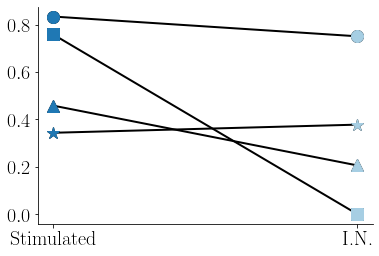

In [32]:
Dir = SpineDir+'Control/'
Name = '15_pot'
with open(Dir+Name+'.json', 'r') as fp: temp = json.load(fp)
nu1 = [temp['nu1']]
nu2 = [temp['nu2']]
P0 = [temp['P_init']]
C0 = [temp['C_init']]
Name = '15_clust'
with open(Dir+Name+'.json', 'r') as fp: temp = json.load(fp)
nu1.append(temp['nu1'])
nu2.append(temp['nu2'])
P0.append(temp['P_init'])
C0.append(temp['C_init'])

col = np.zeros((8,3))
l1 = ColorDict['Sham']
l2 = ColorDict['Control']

b = np.linspace(C[l2],C[l2-1],4).tolist()
fig,ax = plt.subplots(1,1)
plt.plot(np.array(nu1),'o-',label=r'$\nu_1$',lw=0.5*lw,ms=3*lw,color='k')
plt.plot(np.array(nu2),'*-',label=r'$\nu_2$',lw=0.5*lw,ms=3*lw,color='k')
plt.plot(np.array(P0),'s-',label=r'$P_0$',lw=0.5*lw,ms=3*lw,color='k')
plt.plot(np.array(C0),'^-',label=r'$C_0$',lw=0.5*lw,ms=3*lw,color='k')


plt.plot(np.array(nu1[0]),'o',lw=0.5*lw,ms=3*lw,color=C[ColorDict['Control']])
plt.plot(np.array(nu2[0]),'*',lw=0.5*lw,ms=3*lw,color=C[ColorDict['Control']])
plt.plot(np.array(P0[0]),'s',lw=0.5*lw,ms=3*lw,color=C[ColorDict['Control']])
plt.plot(np.array(C0[0]),'^',lw=0.5*lw,ms=3*lw,color=C[ColorDict['Control']])

plt.plot(1,np.array(nu1[1]),'o',lw=0.5*lw,ms=3*lw,color=C[ColorDict['Control']-1])
plt.plot(1,np.array(nu2[1]),'*',lw=0.5*lw,ms=3*lw,color=C[ColorDict['Control']-1])
plt.plot(1,np.array(P0[1]),'s',lw=0.5*lw,ms=3*lw,color=C[ColorDict['Control']-1])
plt.plot(1,np.array(C0[1]),'^',lw=0.5*lw,ms=3*lw,color=C[ColorDict['Control']-1])

plt.xticks([0,1],['Stimulated','I.N.'])

ax.tick_params(axis='both', which='major', labelsize=fs)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

#### Figure 5d

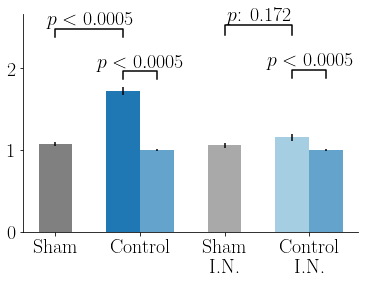

In [33]:
h = 0
Stim = []
StimMean = []
StimErr = []
Stim_e = []
StimMean_e = []
StimErr_e = []
iS     = []
col    = []
for i,N in enumerate(['Sham','Control']):
    Dir = SpineDir+ N + '/'
    D1,A1,_ = ReadFiles(Dir)
    if(N=='Control'):
        a1 =  PreSortData(A1[D1==0],False)
    else:
        a1 = A1[D1==0]
    col.append(C[ColorDict[N]])
    Stim.append(a1[:,3])
    StimMean.append(np.nanmean(a1,axis=0)[3])
    StimErr.append(stats.sem(a1,0,nan_policy='omit')[3])
    iS.append(i)
    if(N=='Control'):
        Stim.append(a1[:,:3].flatten())
        StimMean.append(np.nanmean(a1[:,:3].flatten(),axis=0))
        StimErr.append(stats.sem(a1[:,:3].flatten(),0,nan_policy='omit'))
        iS.append(i+0.5)
        col.append(0.5*C[ColorDict[N]]+0.5*C[ColorDict[N]-1])
    
for i,N in enumerate(['Sham','Control']):
    Dir = SpineDir+ N + '/'    
    D1,A1,_ = ReadFiles(Dir)
    a2 =  A1[D1<0]
    col.append(C[ColorDict[N]-1])
    
    Stim.append(a2[:,3])
    StimMean.append(np.nanmean(a2,axis=0)[3])
    StimErr.append(stats.sem(a2,0,nan_policy='omit')[3])
    iS.append(1*i+2.5)
    if(N=='Control'):
        Stim.append(a1[:,:3].flatten())
        StimMean.append(np.nanmean(a1[:,:3].flatten(),axis=0))
        StimErr.append(stats.sem(a1[:,:3].flatten(),0,nan_policy='omit'))
        iS.append(i+3.0)
        col.append(0.5*C[ColorDict[N]]+0.5*C[ColorDict[N]-1])


fig,ax = plt.subplots(1,1)
ax.bar(iS,StimMean,yerr=StimErr,color = col,width=0.5)

h = barplot_annotate_brackets(1,2, stats.ttest_ind(Stim[1],Stim[2],nan_policy='omit',permutations=1000).pvalue, iS, np.array(StimMean)+np.array(StimErr))
i,j = 4,5
barplot_annotate_brackets(i,j, stats.ttest_ind(Stim[i],Stim[j],nan_policy='omit',permutations=1000).pvalue, iS, np.ones_like(StimMean)*h)


h = barplot_annotate_brackets(0,1, stats.ttest_ind(Stim[0],Stim[1],nan_policy='omit',permutations=1000).pvalue, iS, np.array(StimMean)+np.array(StimErr)+0.5)
i,j = 3,4
barplot_annotate_brackets(i,j, stats.ttest_ind(Stim[i],Stim[j],nan_policy='omit',permutations=1000).pvalue, iS, np.ones_like(StimMean)*h)


ax.tick_params(axis='both', which='major', labelsize=fs)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

plt.xticks([0,1.25,2.5,3.75],[labelDict['Sham'],labelDict['Control'],labelDict['Sham']+'\n I.N.',labelDict['Control']+'\n I.N.'])

plt.show()

#### Figure 5e

([<matplotlib.axis.XTick at 0x137cd5d30>,
 [Text(0.0, 0, 'Sham'),
  Text(1.25, 0, 'Control'),
  Text(2.5, 0, 'Sham\n I.N.'),
  Text(3.75, 0, 'Control\n I.N.')])

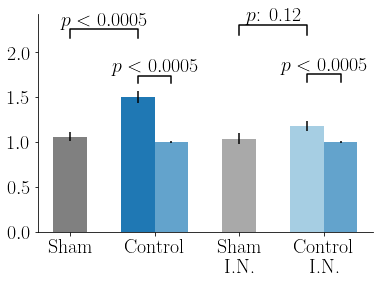

In [34]:
h = 0
Stim = []
StimMean = []
StimErr = []
Stim_e = []
StimMean_e = []
StimErr_e = []
iS     = []
col    = []
for i,N in enumerate(['Sham','Control']):
    Dir = SpineDir+ N + '/'
    D1,A1,_ = ReadFiles(Dir)
    if(N=='Control'):
        a1 =  PreSortData(A1[D1==0],False)
    else:
        a1 = A1[D1==0]
    col.append(C[ColorDict[N]])
    Stim.append(a1[:,-1])
    StimMean.append(np.nanmean(a1,axis=0)[-1])
    StimErr.append(stats.sem(a1,0,nan_policy='omit')[-1])
    iS.append(i)
    if(N=='Control'):
        Stim.append(a1[:,:3].flatten())
        StimMean.append(np.nanmean(a1[:,:3].flatten(),axis=0))
        StimErr.append(stats.sem(a1[:,:3].flatten(),0,nan_policy='omit'))
        iS.append(i+0.5)
        col.append(0.5*C[ColorDict[N]]+0.5*C[ColorDict[N]-1])
    
for i,N in enumerate(['Sham','Control']):
    Dir = SpineDir+ N + '/'
    D1,A1,_ = ReadFiles(Dir)
    a2 =  A1[D1<0]
    col.append(C[ColorDict[N]-1])
    
    Stim.append(a2[:,-1])
    StimMean.append(np.nanmean(a2,axis=0)[-1])
    StimErr.append(stats.sem(a2,0,nan_policy='omit')[-1])
    iS.append(1*i+2.5)
    if(N=='Control'):
        Stim.append(a1[:,:3].flatten())
        StimMean.append(np.nanmean(a1[:,:3].flatten(),axis=0))
        StimErr.append(stats.sem(a1[:,:3].flatten(),0,nan_policy='omit'))
        iS.append(i+3.0)
        col.append(0.5*C[ColorDict[N]]+0.5*C[ColorDict[N]-1])


fig,ax = plt.subplots(1,1)
ax.bar(iS,StimMean,yerr=StimErr,color = col,width=0.5)

h = barplot_annotate_brackets(1,2, stats.ttest_ind(Stim[1],Stim[2],nan_policy='omit',permutations=1000).pvalue, iS, np.array(StimMean)+np.array(StimErr))
i,j = 4,5
barplot_annotate_brackets(i,j, stats.ttest_ind(Stim[i],Stim[j],nan_policy='omit',permutations=1000).pvalue, iS, np.ones_like(StimMean)*h)


h = barplot_annotate_brackets(0,1, stats.ttest_ind(Stim[0],Stim[1],nan_policy='omit',permutations=1000).pvalue, iS, np.array(StimMean)+np.array(StimErr)+0.5)
i,j = 3,4
barplot_annotate_brackets(i,j, stats.ttest_ind(Stim[i],Stim[j],nan_policy='omit',permutations=1000).pvalue, iS, np.ones_like(StimMean)*h)




ax.tick_params(axis='both', which='major', labelsize=fs)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

plt.xticks([0,1.25,2.5,3.75],[labelDict['Sham'],labelDict['Control'],labelDict['Sham']+'\n I.N.',labelDict['Control']+'\n I.N.'])


#### Figure 5f

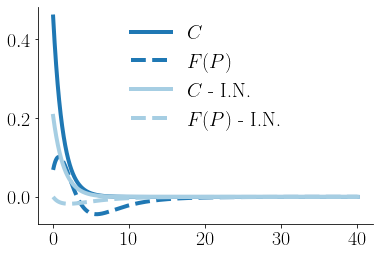

In [35]:
fig1,ax1 = plt.subplots()
Dir = SpineDir+ 'Control/'
Name = '15_pot'
PlotSimulationCFP(Dir,Name,ax1)
Name = '15_clust'
PlotSimulationCFP(Dir,Name,Col=C[ColorDict['Control']-1],ax=ax1,Type='Clust')

ax1.spines["right"].set_visible(False)
ax1.spines["top"].set_visible(False)




### Figure 6

#### Figures 6a-d

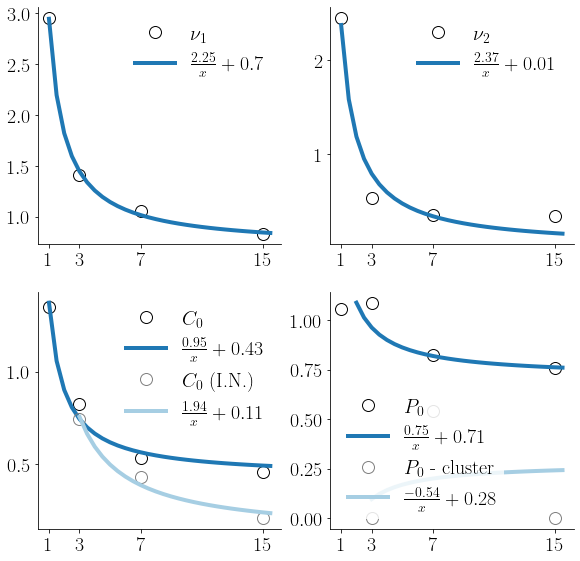

In [36]:
nu1 = []
nu2 = []
C0  = []
P0  = []
for N in ['1','3','7','15']:
    Dir = BaseDir+'CA1_'+N+'Spine/Control/'
    Name = N+'_pot'
    with open(Dir+Name+'.json', 'r') as fp: temp = json.load(fp)
    nu1.append(temp['nu1'])
    nu2.append(temp['nu2'])
    C0.append(temp['C_init'])
    P0.append(temp['P_init'])

spines = np.array([1,3,7,15])
pnu1, _ = curve_fit(func, spines, nu1)
pnu2, _ = curve_fit(func, spines, nu2)
pC0 , _ = curve_fit(func, spines, C0)
pP0 , _ = curve_fit(func, spines, P0)


spines_c = np.array([3,7,15])
C0_c  = []
P0_c  = []
for N in ['3','7','15']:
    Dir = BaseDir+'CA1_'+N+'Spine/Control/'    
    Name = N+'_clust'
    with open(Dir+Name+'.json', 'r') as fp: temp = json.load(fp)
    C0_c.append(temp['C_init'])
    P0_c.append(temp['P_init'])

pC0_c , _ = curve_fit(func, spines_c, C0_c)
pP0_c , _ = curve_fit(func, spines_c, P0_c)

spines2 = np.array([3,7,15])
P02  = []
for N in ['3','7','15']:
    Dir = BaseDir+'CA1_'+N+'Spine/Control/'    
    Name = N+'_pot'
    with open(Dir+Name+'.json', 'r') as fp: temp = json.load(fp)
    P02.append(temp['P_init'])

pP02 , _ = curve_fit(func, spines2, P02)


P03  = []
for N in ['1','3','7','15']:
    Dir = BaseDir+'CA1_'+N+'Spine/Control/'
    Name = N+'_pot'
    with open(Dir+Name+'.json', 'r') as fp: temp = json.load(fp)

    P03.append(temp['P_init'])

pP03 , _ = curve_fit(func, spines, P0,p0=pP02)



spineplot_c = np.arange(3,16,0.5)

spineplot_c2 = np.arange(2,16,0.5)

fig1,ax1 = plt.subplots(2,2,figsize=(9.6,9.6))
ax1 = ax1.ravel()
ax  = ax1[0]
ax.plot(spines,nu1,'ko',fillstyle='none',ms=3*lw,label=r'$\nu_1$',lw=lw)
ax.plot(spineplot,func(spineplot,pnu1[0],pnu1[1]),'-',label=r"$ \frac{"+str(np.round(pnu1[0],2))+"}{x} + "+str(np.round(pnu1[1],2))+"$",color=C[ColorDict['Control']],lw=lw)
leg = ax.legend(prop={'size': fs})
leg.get_frame().set_linewidth(0.0)
ax.set_xticks(spines,spines)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

ax = ax1[1]
ax.plot(spines,nu2,'ko',fillstyle='none',ms=3*lw,label=r'$\nu_2$',lw=lw)
ax.plot(spineplot,func(spineplot,pnu2[0],pnu2[1]),'-',label=r"$ \frac{"+str(np.round(pnu2[0],2))+"}{x} + "+str(np.round(pnu2[1],2))+"$",color=C[ColorDict['Control']],lw=lw)
leg = ax.legend(prop={'size': fs})
leg.get_frame().set_linewidth(0.0)
ax.set_xticks(spines,spines)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)


ax = ax1[2]
ax.plot(spines,C0,'ko',fillstyle='none',ms=3*lw,label=r'$C_0$',lw=lw)
ax.plot(spineplot,func(spineplot,pC0[0],pC0[1]),'-',label=r"$ \frac{"+str(np.round(pC0[0],2))+"}{x} + "+str(np.round(pC0[1],2))+"$",color=C[ColorDict['Control']],lw=lw)
ax.plot(spines_c,C0_c,'o',fillstyle='none',ms=3*lw,color='gray',label=r'$C_0$ (I.N.)')
ax.plot(spineplot_c,func(spineplot_c,pC0_c[0],pC0_c[1]),'-',label=r"$ \frac{"+str(np.round(pC0_c[0],2))+"}{x} + "+str(np.round(pC0_c[1],2))+"$",color=C[ColorDict['Control']-1],lw=lw)
leg = ax.legend(prop={'size': fs})
leg.get_frame().set_linewidth(0.0)
ax.set_xticks(spines,spines)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

ax = ax1[3]
plt.plot(spines,P0,'ko',fillstyle='none',ms=3*lw,label=r'$P_0$',lw=lw)
plt.plot(spineplot_c2,func(spineplot_c2,pP02[0]-0.5,pP02[1]+0.05),'-',label=r"$ \frac{"+str(np.round(pP02[0]-0.5,2))+"}{x} + "+str(np.round(pP02[1]+0.05,2))+"$",color=C[ColorDict['Control']],lw=lw)

plt.plot(spines_c,P0_c,'o',fillstyle='none',ms=3*lw,color='gray',label=r'$P_0$ - cluster')
plt.plot(spineplot_c,func(spineplot_c,pP0_c[0],pP0_c[1]),'-',label=r"$ \frac{"+str(np.round(pP0_c[0],2))+"}{x} + "+str(np.round(pP0_c[1],2))+"$",color=C[ColorDict['Control']-1],lw=lw)
plt.xticks(spines,spines)
leg = ax.legend(prop={'size': fs})
leg.get_frame().set_linewidth(0.0)
ax.set_xticks(spines,spines)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

#### Figure 6e

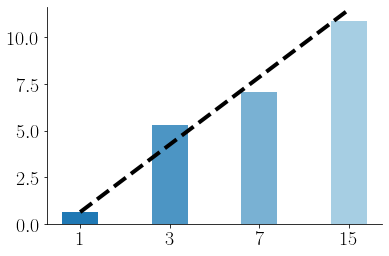

In [37]:
Stim = []
Stim2 = []
StimMean = []
StimErr = []
iS     = []
j=0
for i in [1,3,7,15]:
    for N in ['Control']:
        Dir = BaseDir+'CA1_'+str(i)+'Spine/'+ N + '/'
        if(N=='Control'):
            D1,A1,_ = ReadFiles(Dir)
            A2 = A1[D1<0]
            A1 =  PreSortData(A1[D1==0],False)
        else:
            D1,A1,_ = ReadFiles(Dir)
            A1 = A1[D1==0]
        
        Stim.append(A1[:,3])
        Stim2.append(A2[:,3])
        if('Control' in N):
            iS.append(j)
            j+=2
        else:
            iS.append(j-1.5)

col = np.zeros((8,3))
l1 = ColorDict['CamKII']

a = np.linspace(C[l1],C[l1-1]+(C[l1]-C[l1-1])/2,4)

SumStim = [np.nanmean(S-1)*i for i,S in zip([1,3,7,15],Stim)]
fig,ax = plt.subplots(1,1)
plt.bar(iS,SumStim,color = b,label='Stimulated')

plt.xticks([0,2,4,6],[1,3,7,15])
plt.ylim([plt.gca().get_ylim()[0],plt.gca().get_ylim()[1]+0.2])
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

m,c = np.polyfit([1,3,7,15],SumStim,1)
plt.plot(iS,c*np.array(iS)+m,'k--',lw=lw)

plt.show()

### Figure S1

#### Figures S1a-d

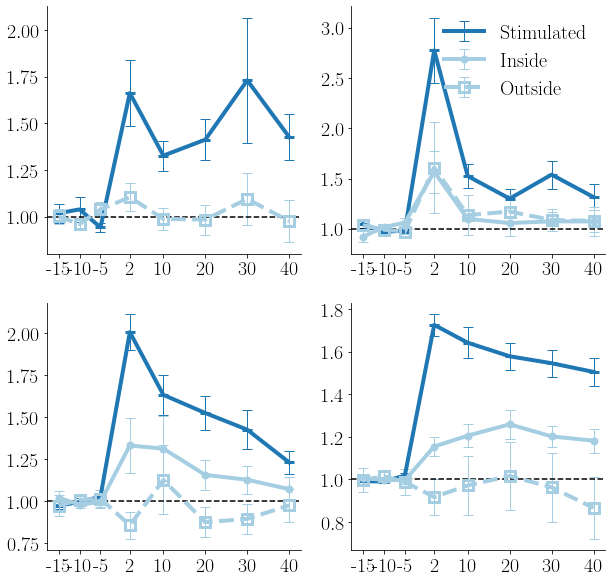

In [38]:
fig,ax=plt.subplots(2,2,figsize=(10,10))
ax = ax.ravel()
for i,N in enumerate([1,3,7,15]):
    Dir = BaseDir+'CA1_'+str(N)+'Spine/Control/'

    PlotStimInOn(Dir,N,ax=ax[i])
    ax[i].spines["right"].set_visible(False)
    ax[i].spines["top"].set_visible(False)
    if(N==3):
        ax[i].legend(prop={'size': fs},frameon=False)
    ax[i].axhline(y=1,ls='--',c='k')

#### Figure S1e

/var/folders/wq/khj25pln1jbddt1m6qz2s8lw0000gn/T/ipykernel_1484/4124115846.py:32: RuntimeWarning: Mean of empty slice
  StimMean.append(np.nanmean(A1,axis=0)[3])
/Users/maximilianeggl/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/maximilianeggl/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/maximilianeggl/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:250: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/var/folders/wq/khj25pln1jbddt1m6qz2s8lw0000gn/T/ipykernel_1484/4124115846.py:41: RuntimeWarning: Mean of empty slice
  StimMean.append(np.nanmean(A1,axis=0)[3])


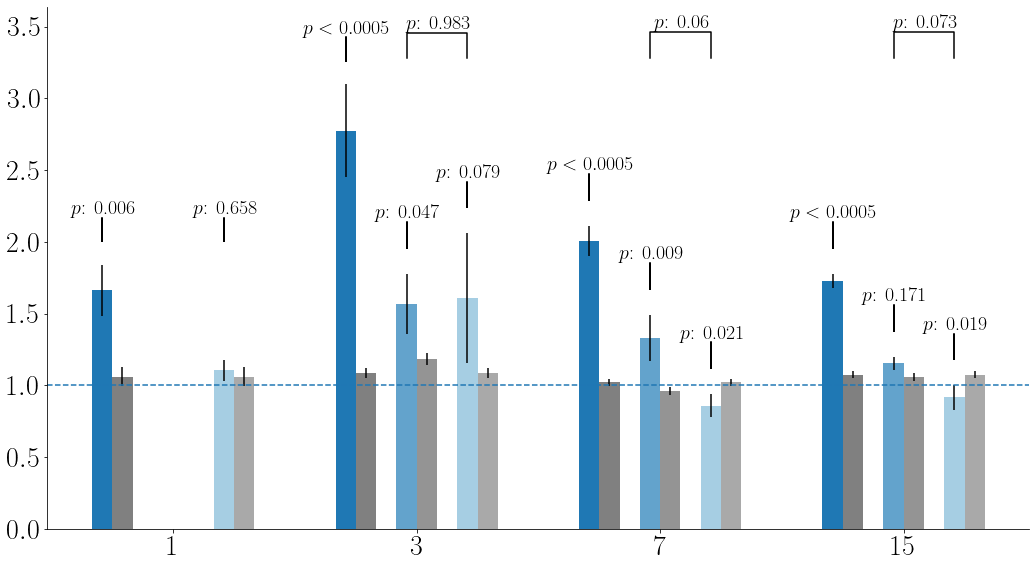

In [39]:
Stim = []
StimMean = []
StimErr = []
iS     = []
Cols = []
j=0
for i in [1,3,7,15]:
    for N in ['Stim','Cluster','Outside']:
        Dir = BaseDir+'CA1_'+str(i)+'Spine/Control/'
        if(N=='Stim'):
            D1,A1,_ = ReadFiles(Dir)
            A1 =  PreSortData(A1[D1==0],False)
            Stim.append(A1[:,3])
            StimMean.append(np.nanmean(A1,axis=0)[3])
            StimErr.append(stats.sem(A1,0,nan_policy='omit')[3])
            iS.append(j)
            j+=0.5
            Cols.append(C[1])
            Dir = BaseDir+'CA1_'+str(i)+'Spine/Sham/'
            D1,A1,_ = ReadFiles(Dir)
            A1 = A1[D1==0]
            Stim.append(A1[:,3])
            StimMean.append(np.nanmean(A1,axis=0)[3])
            StimErr.append(stats.sem(A1,0,nan_policy='omit')[3])
            iS.append(j)
            j+=1.0
            Cols.append(C[-1])
        elif(N=='Cluster'):
            D1,A1,_ = ReadFiles(Dir)
            A1 = A1[D1<0]
            Stim.append(A1[:,3])
            StimMean.append(np.nanmean(A1,axis=0)[3])
            StimErr.append(stats.sem(A1,0,nan_policy='omit')[3])
            iS.append(j)
            j+=0.5
            Cols.append(C[0]*0.5+C[1]*0.5)
            Dir = BaseDir+'CA1_'+str(i)+'Spine/Sham/'
            D1,A1,_ = ReadFiles(Dir)
            A1 = A1[D1<0]
            Stim.append(A1[:,3])
            StimMean.append(np.nanmean(A1,axis=0)[3])
            StimErr.append(stats.sem(A1,0,nan_policy='omit')[3])
            iS.append(j)
            j+=1.0
            Cols.append(C[-2]*0.5+C[-1]*0.5)
            
        elif(N=='Outside'):
            D1,A1,_ = ReadFiles(Dir)
            A1 = A1[np.logical_and(D1>0,D1<2)]
            Stim.append(A1[:,3])
            StimMean.append(np.nanmean(A1,axis=0)[3])
            StimErr.append(stats.sem(A1,0,nan_policy='omit')[3])
            iS.append(j)
            j+=0.5
            Cols.append(C[0])
            Dir = BaseDir+'CA1_'+str(i)+'Spine/Sham/'
            D1,A1,_ = ReadFiles(Dir)
            A1 = A1[D1==0]
            Stim.append(A1[:,3])
            StimMean.append(np.nanmean(A1,axis=0)[3])
            StimErr.append(stats.sem(A1,0,nan_policy='omit')[3])
            iS.append(j)
            j+=1.0
            Cols.append(C[-2])
    j+=1.5
                                             
fig,ax = plt.subplots(1,1,figsize=(17.6,9.6))
plt.bar(iS,StimMean,yerr=StimErr,width=0.5,color=Cols)

plt.xticks([1.75,7.75,13.75,19.75],[1,3,7,15])
ax.tick_params(axis='both', which='major', labelsize=28)
i,j=0,1
h = barplot_annotate_brackets(i,i, stats.ttest_ind(Stim[i],Stim[j],nan_policy='omit',permutations=1000).pvalue, iS, np.array(StimMean)+np.array(StimErr))
i,j = 4,5
barplot_annotate_brackets(i,i, stats.ttest_ind(Stim[i],Stim[j],nan_policy='omit',permutations=1000).pvalue, iS, np.ones_like(StimMean)*h)

i,j=6,7
h1 = barplot_annotate_brackets(i,i, stats.ttest_ind(Stim[i],Stim[j],nan_policy='omit',permutations=1000).pvalue, iS, np.array(StimMean)+np.array(StimErr))

i,j=12,13
h = barplot_annotate_brackets(i,i, stats.ttest_ind(Stim[i],Stim[j],nan_policy='omit',permutations=1000).pvalue, iS, np.array(StimMean)+np.array(StimErr))

i,j=18,19
h = barplot_annotate_brackets(i,i, stats.ttest_ind(Stim[i],Stim[j],nan_policy='omit',permutations=1000).pvalue, iS, np.array(StimMean)+np.array(StimErr))


i,j=10,11
h = barplot_annotate_brackets(i,i, stats.ttest_ind(Stim[i],Stim[j],nan_policy='omit',permutations=1000).pvalue, iS, np.array(StimMean)+np.array(StimErr))

i,j=16,17
h = barplot_annotate_brackets(i,i, stats.ttest_ind(Stim[i],Stim[j],nan_policy='omit',permutations=1000).pvalue, iS, np.array(StimMean)+np.array(StimErr))

i,j=22,23
h = barplot_annotate_brackets(i,i, stats.ttest_ind(Stim[i],Stim[j],nan_policy='omit',permutations=1000).pvalue, iS, np.array(StimMean)+np.array(StimErr))

i,j=8,9
h = barplot_annotate_brackets(i,i, stats.ttest_ind(Stim[i],Stim[j],nan_policy='omit',permutations=1000).pvalue, iS, np.array(StimMean)+np.array(StimErr))

i,j=14,15
h = barplot_annotate_brackets(i,i, stats.ttest_ind(Stim[i],Stim[j],nan_policy='omit',permutations=1000).pvalue, iS, np.array(StimMean)+np.array(StimErr))

i,j=20,21
h = barplot_annotate_brackets(i,i, stats.ttest_ind(Stim[i],Stim[j],nan_policy='omit',permutations=1000).pvalue, iS, np.array(StimMean)+np.array(StimErr))

i,j=8,10
h = barplot_annotate_brackets(i,j, stats.ttest_ind(Stim[i],Stim[j],nan_policy='omit',permutations=1000).pvalue, iS, np.ones_like(StimMean)*h1)

i,j=14,16
h = barplot_annotate_brackets(i,j, stats.ttest_ind(Stim[i],Stim[j],nan_policy='omit',permutations=1000).pvalue, iS, np.ones_like(StimMean)*h1)

i,j=20,22
h = barplot_annotate_brackets(i,j, stats.ttest_ind(Stim[i],Stim[j],nan_policy='omit',permutations=1000).pvalue, iS, np.ones_like(StimMean)*h1)

plt.axhline(1,linestyle='--')
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

plt.show()

#### Figures S1f

/var/folders/wq/khj25pln1jbddt1m6qz2s8lw0000gn/T/ipykernel_1484/226915886.py:32: RuntimeWarning: Mean of empty slice
  StimMean.append(np.nanmean(A1,axis=0)[-1])
/Users/maximilianeggl/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/maximilianeggl/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/maximilianeggl/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:250: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/var/folders/wq/khj25pln1jbddt1m6qz2s8lw0000gn/T/ipykernel_1484/226915886.py:41: RuntimeWarning: Mean of empty slice
  StimMean.append(np.nanmean(A1,axis=0)[-1])


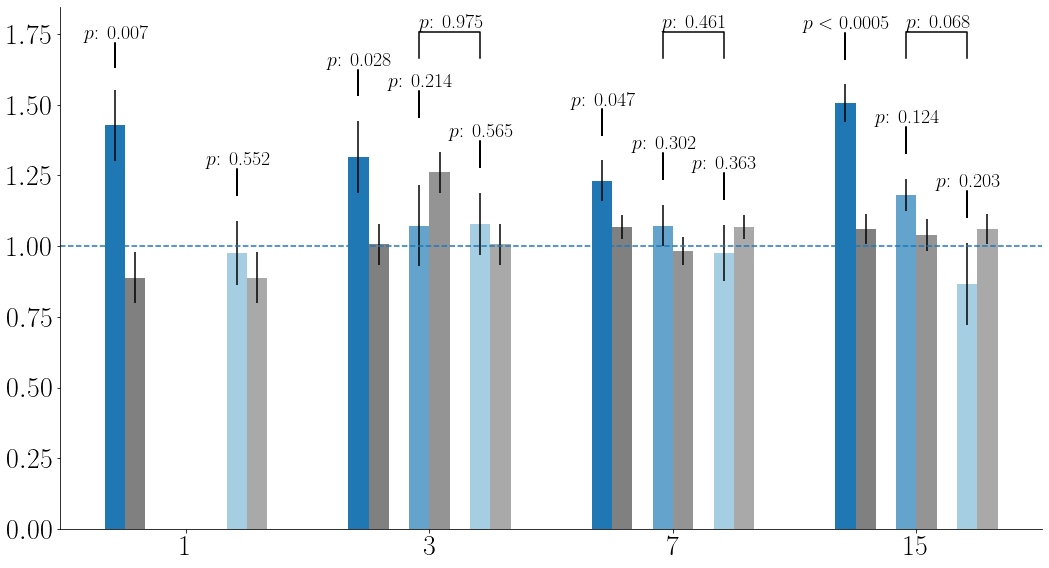

In [40]:
Stim = []
StimMean = []
StimErr = []
iS     = []
Cols = []
j=0
for i in [1,3,7,15]:
    for N in ['Stim','Cluster','Outside']:
        Dir = BaseDir+'CA1_'+str(i)+'Spine/Control/'
        if(N=='Stim'):
            D1,A1,_ = ReadFiles(Dir)
            A1 =  PreSortData(A1[D1==0],False)
            Stim.append(A1[:,-1])
            StimMean.append(np.nanmean(A1,axis=0)[-1])
            StimErr.append(stats.sem(A1,0,nan_policy='omit')[-1])
            iS.append(j)
            j+=0.5
            Cols.append(C[1])
            Dir = BaseDir+'CA1_'+str(i)+'Spine/Sham/'
            D1,A1,_ = ReadFiles(Dir)
            A1 = A1[D1==0]
            Stim.append(A1[:,-1])
            StimMean.append(np.nanmean(A1,axis=0)[-1])
            StimErr.append(stats.sem(A1,0,nan_policy='omit')[-1])
            iS.append(j)
            j+=1.0
            Cols.append(C[-1])
        elif(N=='Cluster'):
            D1,A1,_ = ReadFiles(Dir)
            A1 = A1[D1<0]
            Stim.append(A1[:,-1])
            StimMean.append(np.nanmean(A1,axis=0)[-1])
            StimErr.append(stats.sem(A1,0,nan_policy='omit')[-1])
            iS.append(j)
            j+=0.5
            Cols.append(C[0]*0.5+C[1]*0.5)
            Dir = BaseDir+'CA1_'+str(i)+'Spine/Sham/'
            D1,A1,_ = ReadFiles(Dir)
            A1 = A1[D1<0]
            Stim.append(A1[:,-1])
            StimMean.append(np.nanmean(A1,axis=0)[-1])
            StimErr.append(stats.sem(A1,0,nan_policy='omit')[-1])
            iS.append(j)
            j+=1.0
            Cols.append(C[-2]*0.5+C[-1]*0.5)
            
        elif(N=='Outside'):
            D1,A1,_ = ReadFiles(Dir)
            A1 = A1[np.logical_and(D1>0,D1<2)]
            Stim.append(A1[:,-1])
            StimMean.append(np.nanmean(A1,axis=0)[-1])
            StimErr.append(stats.sem(A1,0,nan_policy='omit')[-1])
            iS.append(j)
            j+=0.5
            Cols.append(C[0])
            Dir = BaseDir+'CA1_'+str(i)+'Spine/Sham/'
            D1,A1,_ = ReadFiles(Dir)
            A1 = A1[D1==0]
            Stim.append(A1[:,-1])
            StimMean.append(np.nanmean(A1,axis=0)[-1])
            StimErr.append(stats.sem(A1,0,nan_policy='omit')[-1])
            iS.append(j)
            j+=1.0
            Cols.append(C[-2])
    j+=1.5
for i,S in enumerate(Stim):
    Stim[i] = S[~np.isnan(S)]


#b = np.linspace(C[l2],C[l2-1],3).tolist()+[C[ColorDict['Sham']]]
#b = b*4
                                             
fig,ax = plt.subplots(1,1,figsize=(17.6,9.6))
plt.bar(iS,StimMean,yerr=StimErr,width=0.5,color=Cols)

plt.xticks([1.75,7.75,13.75,19.75],[1,3,7,15])
ax.tick_params(axis='both', which='major', labelsize=28)
i,j=0,1
h = barplot_annotate_brackets(i,i, stats.ttest_ind(Stim[i],Stim[j],nan_policy='omit').pvalue, iS, np.array(StimMean)+np.array(StimErr))

i,j=6,7
h = barplot_annotate_brackets(i,i, stats.ttest_ind(Stim[i],Stim[j],nan_policy='omit').pvalue, iS, np.array(StimMean)+np.array(StimErr))

i,j=12,13
h = barplot_annotate_brackets(i,i, stats.ttest_ind(Stim[i],Stim[j],nan_policy='omit').pvalue, iS, np.array(StimMean)+np.array(StimErr))

i,j=18,19
h1 = barplot_annotate_brackets(i,i, stats.ttest_ind(Stim[i],Stim[j],nan_policy='omit').pvalue, iS, np.array(StimMean)+np.array(StimErr))

i,j=4,5
h = barplot_annotate_brackets(i,i, stats.ttest_ind(Stim[i],Stim[j],nan_policy='omit').pvalue, iS, np.array(StimMean)+np.array(StimErr))

i,j=10,11
h = barplot_annotate_brackets(i,i, stats.ttest_ind(Stim[i],Stim[j],nan_policy='omit').pvalue, iS, np.array(StimMean)+np.array(StimErr))

i,j=16,17
h = barplot_annotate_brackets(i,i, stats.ttest_ind(Stim[i],Stim[j],nan_policy='omit').pvalue, iS, np.array(StimMean)+np.array(StimErr))

i,j=22,23
h = barplot_annotate_brackets(i,i, stats.ttest_ind(Stim[i],Stim[j],nan_policy='omit').pvalue, iS, np.array(StimMean)+np.array(StimErr))

i,j=8,9
h = barplot_annotate_brackets(i,i, stats.ttest_ind(Stim[i],Stim[j],nan_policy='omit').pvalue, iS, np.array(StimMean)+np.array(StimErr)+0.15)

i,j=14,15
h = barplot_annotate_brackets(i,i, stats.ttest_ind(Stim[i],Stim[j],nan_policy='omit').pvalue, iS, np.array(StimMean)+np.array(StimErr))

i,j=20,21
h = barplot_annotate_brackets(i,i, stats.ttest_ind(Stim[i],Stim[j],nan_policy='omit').pvalue, iS, np.array(StimMean)+np.array(StimErr))


i,j=20,22
h = barplot_annotate_brackets(i,j, stats.ttest_ind(Stim[i],Stim[j],nan_policy='omit').pvalue, iS, h1*np.ones_like(StimMean))
i,j=8,10
h = barplot_annotate_brackets(i,j, stats.ttest_ind(Stim[i],Stim[j],nan_policy='omit').pvalue, iS, h1*np.ones_like(StimMean))

i,j=14,16
h = barplot_annotate_brackets(i,j, stats.ttest_ind(Stim[i],Stim[j],nan_policy='omit').pvalue, iS, h1*np.ones_like(StimMean))

plt.axhline(1,linestyle='--')
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)


### Figure S2

#### Figures S2a

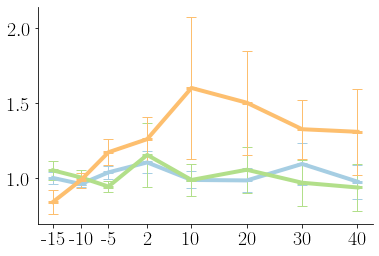

In [41]:
fig,ax=plt.subplots(1,1)
for N in ['Control','CamKII','Calcineurin']:
    if(N=='CamKII'):
        Dir = BaseDir+'CA1_1Spine/'+N+'_alt/'
    else:
        Dir = BaseDir+'CA1_1Spine/'+N+'/'        
    PlotDat(Dir,labelDict[N],ax=ax,PlotColor=C[ColorDict[N]-1],Type='Outside')
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

#### Figures 2Sb

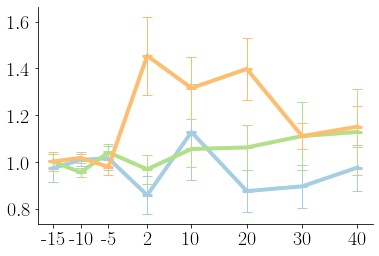

In [42]:
fig,ax=plt.subplots(1,1)
for N in ['Control','CamKII','Calcineurin']:
    Dir = BaseDir+'CA1_7Spine/'+N+'/'        
    PlotDat(Dir,labelDict[N],ax=ax,PlotColor=C[ColorDict[N]-1],Type='Outside')
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

#### Figure S2c

/var/folders/wq/khj25pln1jbddt1m6qz2s8lw0000gn/T/ipykernel_1484/3438180674.py:24: RuntimeWarning: Mean of empty slice
  StimMean.append(np.nanmean(A1,axis=0)[3])
/Users/maximilianeggl/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/maximilianeggl/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/maximilianeggl/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:250: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


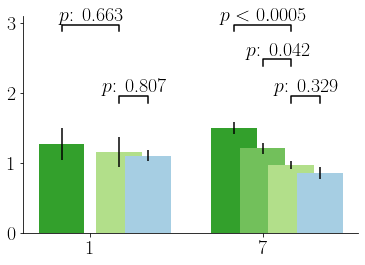

In [43]:
Stim = []
StimMean = []
StimErr = []
iS     = []
j=0
for i in [1,7]:
    for N in ['Stim','Cluster','Outside']:
        if(i==1):
            Dir = BaseDir+'CA1_'+str(i)+'Spine/CamKII_alt/'
        else:
            Dir = BaseDir+'CA1_'+str(i)+'Spine/CamKII/'
        if(N=='Stim'):
            D1,A1,_ = ReadFiles(Dir)
            A1 = A1[D1==0]
            
        elif(N=='Cluster'):
            D1,A1,_ = ReadFiles(Dir)
            A1 = A1[D1<0]
        elif(N=='Outside'):
            D1,A1,_ = ReadFiles(Dir)
            A1 = A1[np.logical_and(D1>0,D1<2)]
        
        Stim.append(A1[:,3])
        StimMean.append(np.nanmean(A1,axis=0)[3])
        StimErr.append(stats.sem(A1,0,nan_policy='omit')[3])
        if('Stim' in N or 'Cluster' in N):
            iS.append(j)
            j+=0.5
        else:
            iS.append(j)
            j+=2
    Dir =  Dir = BaseDir+'CA1_'+str(i)+'Spine/Control/'
    D1,A1,_ = ReadFiles(Dir)
    A1 = A1[np.logical_and(D1>0,D1<2)]
    Stim.append(A1[:,3])
    StimMean.append(np.nanmean(A1,axis=0)[3])
    StimErr.append(stats.sem(A1,0,nan_policy='omit')[3])
    iS.append(j-1.5)



col = np.zeros((8,3))
l1 = ColorDict['Control']
l2 = ColorDict['CamKII']

b = np.linspace(C[l2],C[l2-1],3).tolist()+[C[ColorDict['Control']-1]]
b = b*2
                                             
fig,ax = plt.subplots(1,1)
plt.bar(iS,StimMean,yerr=StimErr,color=b)

plt.xticks(iS[1::4],[1,7])
plt.ylim([plt.gca().get_ylim()[0],plt.gca().get_ylim()[1]+0.2])

i0=0
h1 = barplot_annotate_brackets(i0+2, i0+3,stats.ttest_ind(Stim[i0+2],Stim[i0+3],nan_policy='omit',permutations=1000).pvalue, iS, np.array(StimMean)+np.array(StimErr)+0.4) 
for i0 in [4,]:
    h0 = barplot_annotate_brackets(i0+1, i0+2,stats.ttest_ind(Stim[i0+1],Stim[i0+2],nan_policy='omit',permutations=1000).pvalue, iS, np.array(StimMean)+np.array(StimErr)+1.0) 
    h0 = barplot_annotate_brackets(i0, i0+2,stats.ttest_ind(Stim[i0],Stim[i0+2],nan_policy='omit',permutations=1000).pvalue, iS,np.array(StimMean)+np.array(StimErr)+1.2) 
    h1 = barplot_annotate_brackets(i0+2, i0+3,stats.ttest_ind(Stim[i0+2],Stim[i0+3],nan_policy='omit',permutations=1000).pvalue, iS, np.ones_like(StimMean)*h1)


i0=0
h0 = barplot_annotate_brackets(i0, i0+2,stats.ttest_ind(Stim[i0],Stim[i0+2],nan_policy='omit',permutations=1000).pvalue, iS, np.ones_like(StimMean)*h0)






y1 = 0
y2 = 3.1
plt.ylim([0,3.1])
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

#### Figure S2d

/var/folders/wq/khj25pln1jbddt1m6qz2s8lw0000gn/T/ipykernel_1484/296098209.py:23: RuntimeWarning: Mean of empty slice
  StimMean.append(np.nanmean(A1,axis=0)[-1])
/Users/maximilianeggl/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/maximilianeggl/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/maximilianeggl/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:250: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


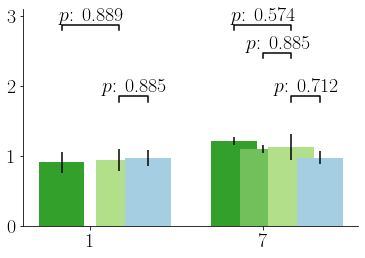

In [44]:

Stim = []
StimMean = []
StimErr = []
iS     = []
j=0
for i in [1,7]:
    for N in ['Stim','Cluster','Outside']:
        if(i==1):
             Dir = BaseDir+'CA1_'+str(i)+'Spine/CamKII_alt/'
        else:
             Dir = BaseDir+'CA1_'+str(i)+'Spine/CamKII/'
        if(N=='Stim'):
            D1,A1,_ = ReadFiles(Dir)
            A1 = A1[D1==0]
        elif(N=='Cluster'):
            D1,A1,_ = ReadFiles(Dir)
            A1 = A1[D1<0]
        elif(N=='Outside'):
            D1,A1,_ = ReadFiles(Dir)
            A1 = A1[np.logical_and(D1>0,D1<2)]
        
        Stim.append(A1[:,-1])
        StimMean.append(np.nanmean(A1,axis=0)[-1])
        StimErr.append(stats.sem(A1,0,nan_policy='omit')[-1])
        if('Stim' in N or 'Cluster' in N):
            iS.append(j)
            j+=0.5
        else:
            iS.append(j)
            j+=2
    Dir = BaseDir+'CA1_'+str(i)+'Spine/Control/'
    D1,A1,_ = ReadFiles(Dir)
    A1 = A1[np.logical_and(D1>0,D1<2)]
    Stim.append(A1[:,-1])
    StimMean.append(np.nanmean(A1,axis=0)[-1])
    StimErr.append(stats.sem(A1,0,nan_policy='omit')[-1])
    iS.append(j-1.5)



col = np.zeros((8,3))
l1 = ColorDict['Control']
l2 = ColorDict['CamKII']

b = np.linspace(C[l2],C[l2-1],3).tolist()+[C[ColorDict['Control']-1]]
b = b*2
                                             
fig,ax = plt.subplots(1,1)
plt.bar(iS,StimMean,yerr=StimErr,color=b)

plt.xticks(iS[1::4],[1,7])
plt.ylim([plt.gca().get_ylim()[0],plt.gca().get_ylim()[1]+0.2])

i=0
h1 = barplot_annotate_brackets(i0+2, i0+3,stats.ttest_ind(Stim[i0+2],Stim[i0+3],nan_policy='omit',permutations=1000).pvalue, iS, np.array(StimMean)+np.array(StimErr)+0.6) 
for i0 in [4,]:
    h0 = barplot_annotate_brackets(i0+1, i0+2,stats.ttest_ind(Stim[i0+1],Stim[i0+2],nan_policy='omit',permutations=1000).pvalue, iS, np.array(StimMean)+np.array(StimErr)+1.0) 
    h0 = barplot_annotate_brackets(i0, i0+2,stats.ttest_ind(Stim[i0],Stim[i0+2],nan_policy='omit',permutations=1000).pvalue, iS,np.array(StimMean)+np.array(StimErr)+1.4) 
    h1 = barplot_annotate_brackets(i0+2, i0+3,stats.ttest_ind(Stim[i0+2],Stim[i0+3],nan_policy='omit',permutations=1000).pvalue, iS, np.ones_like(StimMean)*h1)


i0=0
h0 = barplot_annotate_brackets(i0, i0+2,stats.ttest_ind(Stim[i0],Stim[i0+2],nan_policy='omit',permutations=1000).pvalue, iS, np.ones_like(StimMean)*h0)



plt.ylim([y1,y2])
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

#### Figure S2e

/var/folders/wq/khj25pln1jbddt1m6qz2s8lw0000gn/T/ipykernel_1484/1554912202.py:20: RuntimeWarning: Mean of empty slice
  StimMean.append(np.nanmean(A1,axis=0)[3])
/Users/maximilianeggl/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/maximilianeggl/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/maximilianeggl/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:250: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


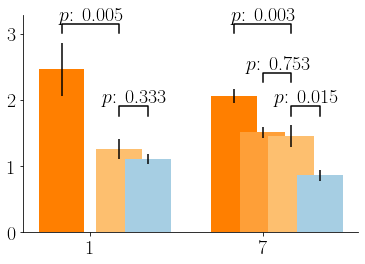

In [50]:
Stim = []
StimMean = []
StimErr = []
iS     = []
j=0
for i in [1,7]:
    for N in ['Stim','Cluster','Outside']:
        Dir = BaseDir+'CA1_'+str(i)+'Spine/Calcineurin/'
        if(N=='Stim'):
            D1,A1,_ = ReadFiles(Dir)
            A1 =  PreSortData(A1[D1==0],False)
        elif(N=='Cluster'):
            D1,A1,_ = ReadFiles(Dir)
            A1 = A1[D1<0]
        elif(N=='Outside'):
            D1,A1,_ = ReadFiles(Dir)
            A1 = A1[np.logical_and(D1>0,D1<2)]
        
        Stim.append(A1[:,3])
        StimMean.append(np.nanmean(A1,axis=0)[3])
        StimErr.append(stats.sem(A1,0,nan_policy='omit')[3])
        if('Stim' in N or 'Cluster' in N):
            iS.append(j)
            j+=0.5
        else:
            iS.append(j)
            j+=2
    Dir = BaseDir+'CA1_'+str(i)+'Spine/Control/'
    D1,A1,_ = ReadFiles(Dir)
    A1 = A1[np.logical_and(D1>0,D1<2)]
    Stim.append(A1[:,3])
    StimMean.append(np.nanmean(A1,axis=0)[3])
    StimErr.append(stats.sem(A1,0,nan_policy='omit')[3])
    iS.append(j-1.5)



col = np.zeros((8,3))
l1 = ColorDict['Control']
l2 = ColorDict['Calcineurin']

b = np.linspace(C[l2],C[l2-1],3).tolist()+[C[ColorDict['Control']-1]]
b = b*2
                                             
fig,ax = plt.subplots(1,1)
plt.bar(iS,StimMean,yerr=StimErr,color=b)

plt.xticks(iS[1::4],[1,7])
plt.ylim([plt.gca().get_ylim()[0],plt.gca().get_ylim()[1]+0.2])

i0=0
h0 = barplot_annotate_brackets(i0, i0+2,stats.ttest_ind(Stim[i0],Stim[i0+2],nan_policy='omit',permutations=1000).pvalue, iS, np.array(StimMean)+np.array(StimErr))


for i0 in [4,]:
    h1 = barplot_annotate_brackets(i0+1, i0+2,stats.ttest_ind(Stim[i0+1],Stim[i0+2],nan_policy='omit',permutations=1000).pvalue, iS, np.array(StimMean)+np.array(StimErr)+0.5) 
    h1 = barplot_annotate_brackets(i0, i0+2,stats.ttest_ind(Stim[i0],Stim[i0+2],nan_policy='omit',permutations=1000).pvalue, iS, np.ones_like(StimMean)*h0)
    h1 = barplot_annotate_brackets(i0+2, i0+3,stats.ttest_ind(Stim[i0+2],Stim[i0+3],nan_policy='omit',permutations=1000).pvalue, iS, np.array(StimMean)+np.array(StimErr))    

i0=0
h1 = barplot_annotate_brackets(i0+2, i0+3,stats.ttest_ind(Stim[i0+2],Stim[i0+3],nan_policy='omit',permutations=1000).pvalue, iS, np.ones_like(StimMean)*h1)

plt.ylim([plt.gca().get_ylim()[0],plt.gca().get_ylim()[1]+0.5])
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

y1,y2 = plt.gca().get_ylim()[0],plt.gca().get_ylim()[1]

plt.savefig('Calcineurin_tot.eps',format='eps')

#### Figure S2f

/var/folders/wq/khj25pln1jbddt1m6qz2s8lw0000gn/T/ipykernel_1484/1610037469.py:20: RuntimeWarning: Mean of empty slice
  StimMean.append(np.nanmean(A1,axis=0)[-1])
/Users/maximilianeggl/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/maximilianeggl/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/maximilianeggl/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:250: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


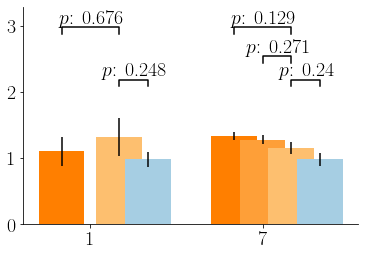

In [46]:
Stim = []
StimMean = []
StimErr = []
iS     = []
j=0
for i in [1,7]:
    for N in ['Stim','Cluster','Outside']:
        Dir = BaseDir+'CA1_'+str(i)+'Spine/Calcineurin/'
        if(N=='Stim'):
            D1,A1,_ = ReadFiles(Dir)
            A1 =  PreSortData(A1[D1==0],False)
        elif(N=='Cluster'):
            D1,A1,_ = ReadFiles(Dir)
            A1 = A1[D1<0]
        elif(N=='Outside'):
            D1,A1,_ = ReadFiles(Dir)
            A1 = A1[np.logical_and(D1>0,D1<2)]
        
        Stim.append(A1[:,-1])
        StimMean.append(np.nanmean(A1,axis=0)[-1])
        StimErr.append(stats.sem(A1,0,nan_policy='omit')[-1])
        if('Stim' in N or 'Cluster' in N):
            iS.append(j)
            j+=0.5
        else:
            iS.append(j)
            j+=2
    Dir = BaseDir+'CA1_'+str(i)+'Spine/Control/'
    D1,A1,_ = ReadFiles(Dir)
    A1 = A1[np.logical_and(D1>0,D1<2)]
    Stim.append(A1[:,-1])
    StimMean.append(np.nanmean(A1,axis=0)[-1])
    StimErr.append(stats.sem(A1,0,nan_policy='omit')[-1])
    iS.append(j-1.5)



col = np.zeros((8,3))
l1 = ColorDict['Control']
l2 = ColorDict['Calcineurin']

b = np.linspace(C[l2],C[l2-1],3).tolist()+[C[ColorDict['Control']-1]]
b = b*2
                                             
fig,ax = plt.subplots(1,1)
plt.bar(iS,StimMean,yerr=StimErr,color=b)

plt.xticks(iS[1::4],[1,7])
plt.ylim([plt.gca().get_ylim()[0],plt.gca().get_ylim()[1]+0.2])

i=0
h1 = barplot_annotate_brackets(i0+2, i0+3,stats.ttest_ind(Stim[i0+2],Stim[i0+3],nan_policy='omit',permutations=1000).pvalue, iS, np.array(StimMean)+np.array(StimErr)+0.4) 
for i0 in [4,]:
    h0 = barplot_annotate_brackets(i0+1, i0+2,stats.ttest_ind(Stim[i0+1],Stim[i0+2],nan_policy='omit',permutations=1000).pvalue, iS, np.array(StimMean)+np.array(StimErr)+1.0) 
    h0 = barplot_annotate_brackets(i0, i0+2,stats.ttest_ind(Stim[i0],Stim[i0+2],nan_policy='omit',permutations=1000).pvalue, iS,np.array(StimMean)+np.array(StimErr)+1.4) 
    h1 = barplot_annotate_brackets(i0+2, i0+3,stats.ttest_ind(Stim[i0+2],Stim[i0+3],nan_policy='omit',permutations=1000).pvalue, iS, np.ones_like(StimMean)*h1)


i0=0
h0 = barplot_annotate_brackets(i0, i0+2,stats.ttest_ind(Stim[i0],Stim[i0+2],nan_policy='omit',permutations=1000).pvalue, iS, np.ones_like(StimMean)*h0)



plt.ylim([y1,y2])
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

### Figure S3

#### Figures S3a-d

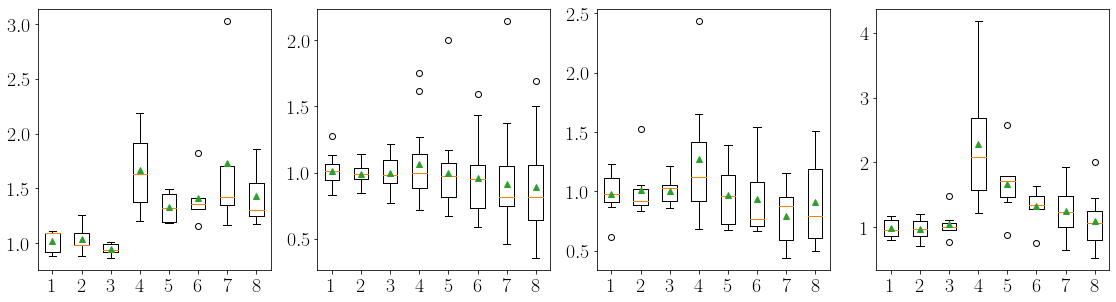

In [47]:
SpineDir = BaseDir + 'CA1_1Spine/'
fig,ax = plt.subplots(1,4,figsize=(19.2,4.8))
ax = ax.ravel()
sDir = SpineDir+'Sham/'
Dir = SpineDir+'Control/'
Dir2 = [Dir,sDir]
Name = '1_pot'
PlotName = 'Test'
PlotFitBox(Dir2,Type='stim',ax = ax[0])
Dir2 = [sDir,Dir]
Name = '1_pot'
PlotName = 'Test'
PlotFitBox(Dir2,Type='NoSort',ax = ax[1])
sDir = SpineDir+'CamKII_alt/'
Dir = SpineDir+'Calcineurin/'
Dir2 = [Dir,sDir]

PlotFitBox(Dir2,Type='NoSort',ax = ax[3])
Dir2 = [sDir,Dir]

PlotFitBox(Dir2,Type='NoSort',ax = ax[2])

#### Figures S3e-h

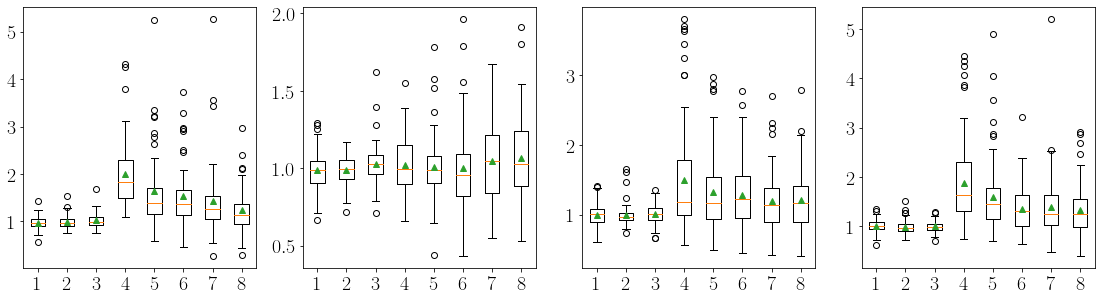

In [48]:
SpineDir = BaseDir + 'CA1_7Spine/'
fig,ax = plt.subplots(1,4,figsize=(19.2,4.8))
ax = ax.ravel()
sDir = SpineDir+'Sham/'
Dir = SpineDir+'Control/'
Dir2 = [Dir,sDir]
Name = '_pot'
PlotName = 'Test'
PlotFitBox(Dir2,Type='stim',ax = ax[0])
Dir2 = [sDir,Dir]

PlotFitBox(Dir2,Type='NoSort',ax = ax[1])
sDir = SpineDir+'CamKII/'
Dir = SpineDir+'Calcineurin/'
Dir2 = [Dir,sDir]

PlotFitBox(Dir2,Type='NoSort',ax = ax[3])
Dir2 = [sDir,Dir]

PlotFitBox(Dir2,Type='NoSort',ax = ax[2])

#### Figures S3i-l

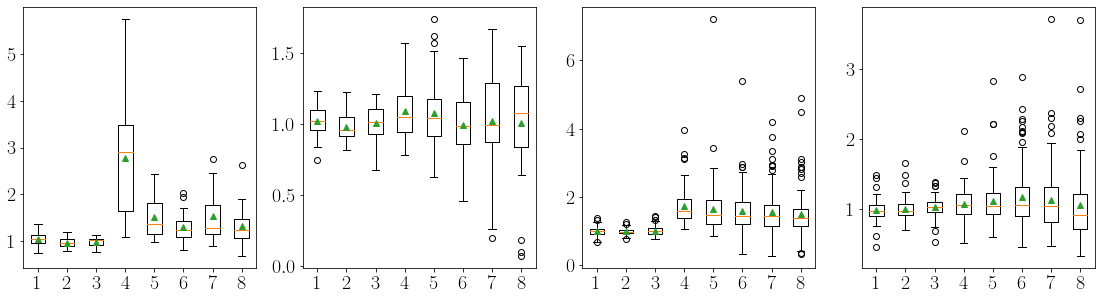

In [49]:
SpineDir = BaseDir + 'CA1_3Spine/'
fig,ax = plt.subplots(1,4,figsize=(19.2,4.8))
ax = ax.ravel()
sDir = SpineDir+'Sham/'
Dir = SpineDir+'Control/'
Dir2 = [Dir,sDir]

PlotFitBox(Dir2,Type='stim',ax = ax[0])
Dir2 = [sDir,Dir]

PlotFitBox(Dir2,Type='NoSort',ax = ax[1])
SpineDir = BaseDir + 'CA1_15Spine/'
ax = ax.ravel()
sDir = SpineDir+'Sham/'
Dir = SpineDir+'Control/'
Dir2 = [Dir,sDir]
PlotFitBox(Dir2,Type='stim',ax = ax[2])
Dir2 = [sDir,Dir]
PlotFitBox(Dir2,Type='NoSort',ax = ax[3])